## Deep Learning Project
### Neural Machine Translation  
#### Group 17 - Susan Wang (M20170548)


## Introduction
This notebook is a modified version of a project from Udacity´s Natural Language Processing course. 

The original project involves creating neural translation models to translate sentences from English to French. This modified project does the reverse, from French to English, so that we can better assess the fluency of the resulting translations. We also applied additional techniques to analyse and evaluate the models.

In [1]:
import collections

import numpy as np
import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers import Embedding, CuDNNLSTM, GlobalMaxPooling1D, GlobalAveragePooling1D, CuDNNGRU
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.utils.vis_utils import plot_model
import helper

import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [3]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

## Dataset
The provided dataset contains a small vocabulary of English and French sentences. 

In [236]:
english_sentences = helper.load_data('data/small_vocab_en')
french_sentences = helper.load_data('data/small_vocab_fr')

In [5]:
type(english_sentences)

list

In [7]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les Ã©tats-unis est gÃ©nÃ©ralement froid en juillet , et il gÃ¨le habituellement en novembre .


In [8]:
len(english_sentences), len(french_sentences)

(137861, 137861)

The dataset provided has been pre-processed slightly, ie. converted to lower case and the punctuations have been delimited with spaces. However, more processing will be required.

### Vocabulary
Let´s check the size of the vocabulary. This will affect the complexity of the machine translation task.

In [239]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English sentences.'.format(len(english_sentences)))
print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French sentences.'.format(len(french_sentences)))
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

137861 English sentences.
1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

137861 French sentences.
1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


It looks like the dataset has been considerably simplifiied and only contains a couple of hundred words. At the same time, it seems each word has occurred many times, suggesting there are sufficient data to train the models properly.

## Preprocess
In order to apply deep learning to natural language processing, we need to convert each word into a unique integer value. And for RNN in Keras, the input sentences need to be of a fixed length. Therefore, the following section contains these steps.
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

In [10]:
def tokenize(x):

    tok = Tokenizer()
    tok.fit_on_texts(x)
    return tok.texts_to_sequences(x), tok
tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we will add padding to make them the same. 


In [11]:
def pad(x, length=None):

    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen=length, padding="post")
tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline

In [240]:
def preprocess(x, y):

    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

### Analyse input and output sentences

In [13]:
preproc_french_sentences, preproc_english_sentences, french_tokenizer, english_tokenizer =\
    preprocess(french_sentences, english_sentences)
    
max_french_sequence_length = preproc_french_sentences.shape[1]
max_english_sequence_length = preproc_english_sentences.shape[1]
french_vocab_size = len(french_tokenizer.word_index)
english_vocab_size = len(english_tokenizer.word_index)

print('Data Preprocessed')
print("Max French sentence length:", max_french_sequence_length)
print("Max English sentence length:", max_english_sequence_length)
print("French vocabulary size:", french_vocab_size)
print("English vocabulary size:", english_vocab_size)

Data Preprocessed
Max French sentence length: 21
Max English sentence length: 15
French vocabulary size: 345
English vocabulary size: 199


In [14]:
preproc_french_sentences.shape

(137861, 21)

In [15]:
preproc_english_sentences.shape

(137861, 15, 1)

In [16]:
input_sentences = preproc_french_sentences
output_sentences = preproc_english_sentences

In [17]:
input_vocab_size = french_vocab_size
output_vocab_size = english_vocab_size

In [18]:
max_input_seq_length = max_french_sequence_length
max_output_seq_length = max_english_sequence_length

In [19]:
max_seq_length = max(max_input_seq_length, max_output_seq_length)

In [20]:
input_tokenizer = french_tokenizer
output_tokenizer = english_tokenizer

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_sentences, output_sentences, test_size=0.15, random_state=42)

In [22]:
!mkdir "log_dir"

A subdirectory or file log_dir already exists.


In [23]:
out_dir ="out"

In [24]:
%pprint

Pretty printing has been turned OFF


## Models
In this section, we will experiment with the following neural network architectures.

- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN
- Model 4 is a Encoder-Decoder RNN
- Model 5 is a combined model 1 - Bidirectional RNN with Embedding but without encoder-decoder
- Model 6 is a combined model 2 - Bidirectional RNN with Embedding but with encoder-decoder


In [25]:
import itertools

In [26]:
def ints_to_text(ints, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
#    index_to_words[0] = '<PAD>'
    index_to_words[0] = ' '    
    return ' '.join([index_to_words[n] for n in ints])

In [284]:
def logits_to_text(logits, tokenizer):

    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
#    index_to_words[0] = '<PAD>'
    index_to_words[0] = ' '
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


### Model 1: Simple RNN (GRU)

In [28]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [29]:
num_rnn_units = 128
learning_rate = 0.01

In [30]:
def simple_model(input_shape, max_sequence_length, input_vocab_size, output_vocab_size):

    # Build the layers    
    input_seq = Input(input_shape[1:])
    hidden1 = CuDNNGRU(num_rnn_units, return_sequences=True)(input_seq)
    output = TimeDistributed(Dense(output_vocab_size, activation="softmax"))(hidden1)
    model = Model(inputs=input_seq, outputs=output)
    print(model.summary()) 
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [41]:
modelcheckpoint = ModelCheckpoint(filepath=out_dir+"/simple.{epoch:02d}.hdf5", monitor="val_loss", save_best_only=True)

earlystopping = EarlyStopping(monitor="val_loss", patience=5)

tensorboard = TensorBoard(log_dir="log_dir", histogram_freq=1)

callback_list = [earlystopping, modelcheckpoint]

In [32]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(x_train, max_seq_length)
tmp_x = tmp_x.reshape((-1, tmp_x.shape[1], 1))
tmp_x.shape

(117181, 21, 1)

In [42]:
# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_seq_length,
    input_vocab_size+1,
    output_vocab_size+1
    )


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 21, 128)           50304     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 200)           25800     
Total params: 76,104
Trainable params: 76,104
Non-trainable params: 0
_________________________________________________________________
None


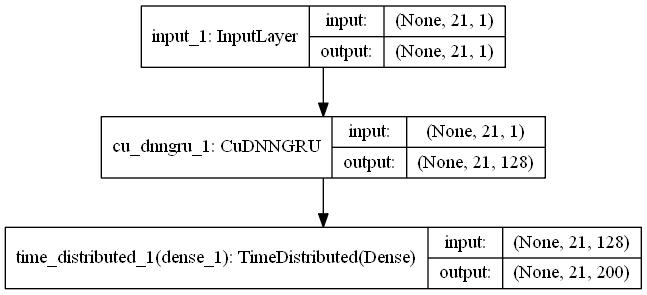

In [34]:
plot_model(simple_rnn_model, to_file='simple_rnn_model.png', show_shapes=True)

In [35]:
tmp_x.shape

(117181, 21, 1)

In [36]:
tmp_y = pad(y_train, max_seq_length)
tmp_y = tmp_y.reshape((-1, max_seq_length, 1))

In [37]:
tmp_y.shape

(117181, 21, 1)

In [43]:
history1 = simple_rnn_model.fit(tmp_x, tmp_y, batch_size=516, epochs=30, validation_split=0.2, callbacks=callback_list)

Train on 93744 samples, validate on 23437 samples
Epoch 1/30
93744/93744 [==============================] - 2s 25us/step - loss: 1.3462 - acc: 0.6659 - val_loss: 0.7867 - val_acc: 0.7601
Epoch 2/30
93744/93744 [==============================] - 2s 21us/step - loss: 0.6893 - acc: 0.7860 - val_loss: 0.6292 - val_acc: 0.7989
Epoch 3/30
93744/93744 [==============================] - 2s 21us/step - loss: 0.6024 - acc: 0.8018 - val_loss: 0.5707 - val_acc: 0.8084
Epoch 4/30
93744/93744 [==============================] - 2s 21us/step - loss: 0.5429 - acc: 0.8133 - val_loss: 0.5206 - val_acc: 0.8219
Epoch 5/30
93744/93744 [==============================] - 2s 21us/step - loss: 0.5520 - acc: 0.8116 - val_loss: 0.5091 - val_acc: 0.8259
Epoch 6/30
93744/93744 [==============================] - 2s 20us/step - loss: 0.4969 - acc: 0.8272 - val_loss: 0.4822 - val_acc: 0.8352
Epoch 7/30
93744/93744 [==============================] - 2s 21us/step - loss: 0.4853 - acc: 0.8298 - val_loss: 0.4749 - val_acc

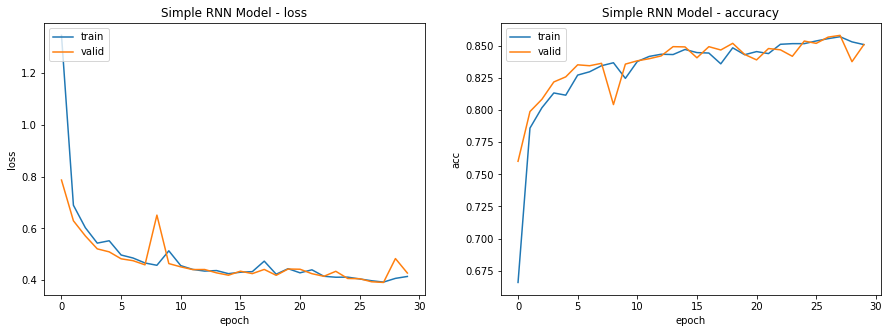

<Figure size 432x288 with 0 Axes>

In [44]:
plt.figure(figsize=(15, 5))
    
ax = plt.subplot(1,2, 1)   
# summarize history for accuracy
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Simple RNN Model - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

ax2 = plt.subplot(1,2, 2)
# summarize history for accuracy
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Simple RNN Model - accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.savefig('simple_rnn.png')

In [45]:
# evaluate the skill of the model
def evaluate_model(model, input_seqs, output_seqs):
    actual, predicted, source = list(), list(), list()
    for i, in_seq in enumerate(input_seqs):
        # translate encoded source text
        in_seq = in_seq.reshape((1, in_seq.shape[0], -1))
        fromText = ints_to_text(input_seqs[i],  input_tokenizer)
        target = ints_to_text(itertools.chain.from_iterable(output_seqs[i]),  output_tokenizer)
        translation = logits_to_text(model.predict(in_seq)[0],  output_tokenizer)
#        if i < 10:
#            print('src=[%s], target=[%s], predicted=[%s]' % (source, target, translation))
        source.append(fromText)
        actual.append([target.split()])
        predicted.append(translation.split())
    df = pd.DataFrame({"from" : source, "target" : actual, "predicted" : predicted})
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    return df

In [156]:
res_df1 = evaluate_model(simple_rnn_model, x_test, y_test)

BLEU-1: 0.748662
BLEU-2: 0.651351
BLEU-3: 0.603070
BLEU-4: 0.507528


In [273]:
data = [{"bleu-1":0.748662, "bleu-2":0.651351, "bleu-3":0.603070, "bleu-4":0.507528}]

In [274]:
bleu_df = pd.DataFrame(data, index =['basic']) 

In [275]:
bleu_df

,bleu-1,bleu-2,bleu-3,bleu-4
basic,0.748662,0.651351,0.60307,0.507528


In [157]:
pd.set_option('display.max_colwidth', -1)

In [159]:
res_df1.head(10)

,from,target,predicted
0,californie est parfois sec au mois de mai et il est parfois merveilleux en fã©vrier,"[[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]]","[california, is, sometimes, busy, during, august, but, it, is, usually, in, in, summer]"
1,californie est jamais chaud pendant l' automne mais il est jamais sec en mars,"[[california, is, never, hot, during, autumn, but, it, is, never, dry, in, march]]","[california, is, never, hot, during, autumn, but, it, is, usually, hot, in, summer]"
2,les ã©tats unis est parfois pluvieux en janvier mais il est doux en mai,"[[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]]","[the, united, states, is, sometimes, quiet, during, january, but, it, is, usually, in, september]"
3,ils aiment les pommes les oranges et les poires,"[[they, like, apples, oranges, and, pears]]","[they, dislike, bananas, lemons, and, lemons]"
4,il n'aime les mangues et les fraises,"[[he, dislikes, mangoes, and, strawberries]]","[he, dislikes, oranges, and, and]"
5,le pamplemousse est son fruit prã©fã©rã© mais le citron est votre favori,"[[the, grapefruit, is, her, favorite, fruit, but, the, lemon, is, your, favorite]]","[the, grapefruit, is, her, least, favorite, but, the, lemon, is, my, favorite]"
6,l' inde est parfois agrã©able au cours de l' automne mais il est gã©nã©ralement agrã©able en mars,"[[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, nice, in, march]]","[india, is, never, dry, during, november, and, it, is, never, in, in]"
7,votre fruit le plus aimã© est la pomme mais son plus aimã© est la pãªche,"[[your, most, loved, fruit, is, the, apple, but, his, most, loved, is, the, peach]]","[your, least, loved, fruit, is, the, strawberry, but, his, most, loved, is, the, strawberry]"
8,les ã©tats unis est froid pendant l' hiver et il est parfois relaxant en juin,"[[the, united, states, is, cold, during, winter, and, it, is, sometimes, relaxing, in, june]]","[the, united, states, is, cold, during, summer, and, it, is, usually, hot, in, november]"
9,i comme le pamplemousse les pommes et les mangues,"[[i, like, grapefruit, apples, and, mangoes]]","[when, think, grapefruit, peaches, and, grapes]"


#### observation:
The program correctly predicted many words, but sometimes get keywords wrong, and sometimes repeats the same word multiple times, and sometimes miss words and ends the sentence in illogical places. The BLEU-1 score is 0.749, suggesting the accuracy of unigram words, but BLEU-4 of 0.508 suggested that it only gets 4 consecutive words correctly roughly half the number of times.

### Model 2: Embedding

In [49]:
num_rnn_units= 128
learning_rate = 0.01
test_batch_size = 512
embedding_dim = 128

In [50]:
def embed_model(input_shape, max_sequence_length, input_vocab_size, output_vocab_size):

    input_seq = Input(input_shape[1:])    
    embed = Embedding(input_vocab_size, embedding_dim, input_length=input_shape[1])(input_seq)
    hidden1 = CuDNNGRU(num_rnn_units, return_sequences=True)(embed)
    output = TimeDistributed(Dense(output_vocab_size, activation="softmax"))(hidden1)
    model = Model(inputs=input_seq, outputs=output)
    print(model.summary()) 
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])    
    return model

In [51]:
modelcheckpoint = ModelCheckpoint(filepath=out_dir+"/embed.{epoch:02d}.hdf5", monitor="val_loss", save_best_only=True)

earlystopping = EarlyStopping(monitor="val_loss", patience=5)

tensorboard = TensorBoard(log_dir="log_dir", histogram_freq=1)

callback_list = [earlystopping, modelcheckpoint]

In [58]:
# Reshaping the input to work with an embedding model
tmp_x = pad(x_train, max_seq_length)

In [64]:
tmp_y = pad(y_train, max_seq_length)
tmp_y = tmp_y.reshape((-1, max_seq_length, 1))

In [65]:
# Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    max_seq_length,
    input_vocab_size+1,
    output_vocab_size+1)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 21, 128)           44288     
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 21, 128)           99072     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 21, 200)           25800     
Total params: 169,160
Trainable params: 169,160
Non-trainable params: 0
_________________________________________________________________
None


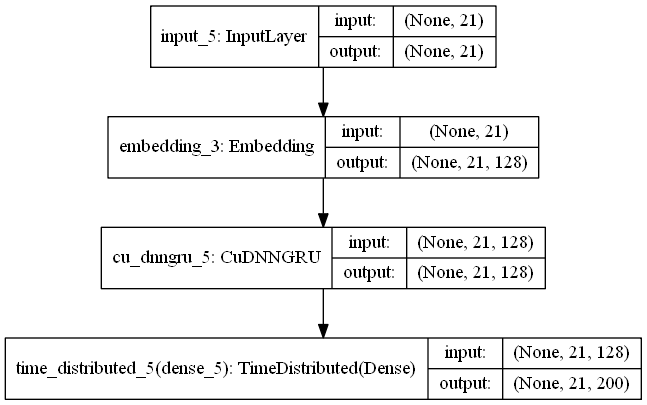

In [97]:
plot_model(embed_rnn_model, to_file='embed_rnn_model.png', show_shapes=True)

In [67]:
history = embed_rnn_model.fit(tmp_x, tmp_y, batch_size=test_batch_size, epochs=30, validation_split=0.2, callbacks=callback_list)

Train on 93744 samples, validate on 23437 samples
Epoch 1/30
93744/93744 [==============================] - 3s 29us/step - loss: 0.9454 - acc: 0.7734 - val_loss: 0.3305 - val_acc: 0.8794
Epoch 2/30
93744/93744 [==============================] - 2s 23us/step - loss: 0.3115 - acc: 0.8815 - val_loss: 0.3052 - val_acc: 0.8824
Epoch 3/30
93744/93744 [==============================] - 2s 22us/step - loss: 0.2982 - acc: 0.8836 - val_loss: 0.2986 - val_acc: 0.8838
Epoch 4/30
93744/93744 [==============================] - 2s 22us/step - loss: 0.3371 - acc: 0.8777 - val_loss: 0.3006 - val_acc: 0.8836
Epoch 5/30
93744/93744 [==============================] - 2s 22us/step - loss: 0.2954 - acc: 0.8843 - val_loss: 0.2973 - val_acc: 0.8841
Epoch 6/30
93744/93744 [==============================] - 2s 22us/step - loss: 0.2917 - acc: 0.8850 - val_loss: 0.2927 - val_acc: 0.8852
Epoch 7/30
93744/93744 [==============================] - 2s 22us/step - loss: 0.2894 - acc: 0.8855 - val_loss: 0.2913 - val_acc

In [68]:
history2 = history

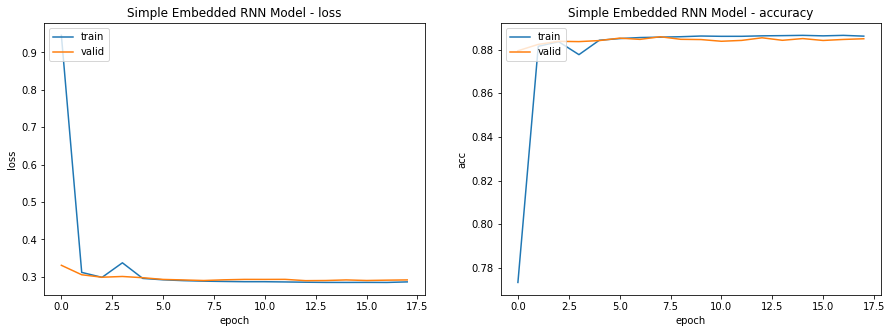

<Figure size 432x288 with 0 Axes>

In [111]:
plt.figure(figsize=(15, 5))
    
ax = plt.subplot(1,2, 1)   
# summarize history for accuracy
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Simple Embedded RNN Model - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

ax2 = plt.subplot(1,2, 2)
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Simple Embedded RNN Model - accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.savefig('simple_embedded_rnn.png')

In [96]:
embed_rnn_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 21, 128)           44288     
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 21, 128)           99072     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 21, 200)           25800     
Total params: 169,160
Trainable params: 169,160
Non-trainable params: 0
_________________________________________________________________


In [100]:
x_test[0]

array([62,  1,  8, 63, 15, 25, 22, 47,  6,  3,  1,  8, 57,  2, 53,  0,  0,
        0,  0,  0,  0])

In [108]:
# evaluate the skill of the model 
def evaluate_model2(model, input_seqs, output_seqs):
    actual, predicted, source = list(), list(), list()
    for i, in_seq in enumerate(input_seqs):
        in_seq = in_seq.reshape((1, -1))
        fromText = ints_to_text(input_seqs[i],  input_tokenizer)
        target = ints_to_text(itertools.chain.from_iterable(output_seqs[i]),  output_tokenizer)
        translation = logits_to_text(model.predict(in_seq)[0],  output_tokenizer)
        source.append(fromText)
        actual.append([target.split()])
        predicted.append(translation.split())
    df = pd.DataFrame({"from" : source, "target" : actual, "predicted" : predicted})
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    return df

In [109]:
x_test.shape

(20680, 21)

In [160]:
res_df2 = evaluate_model2(embed_rnn_model, x_test, y_test)

BLEU-1: 0.799664
BLEU-2: 0.719834
BLEU-3: 0.684355
BLEU-4: 0.607672


In [276]:
bleu_df.loc["embed"] = [0.799664, 0.719834, 0.684355, 0.607672]

In [161]:
res_df2.head(10)

,from,target,predicted
0,californie est parfois sec au mois de mai et il est parfois merveilleux en fã©vrier,"[[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]]","[california, is, sometimes, dry, during, may, but, it, is, sometimes, in, in, autumn]"
1,californie est jamais chaud pendant l' automne mais il est jamais sec en mars,"[[california, is, never, hot, during, autumn, but, it, is, never, dry, in, march]]","[california, is, never, hot, during, summer, but, it, is, sometimes, hot, in, march]"
2,les ã©tats unis est parfois pluvieux en janvier mais il est doux en mai,"[[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]]","[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]"
3,ils aiment les pommes les oranges et les poires,"[[they, like, apples, oranges, and, pears]]","[they, like, mangoes, mangoes, and, lemons]"
4,il n'aime les mangues et les fraises,"[[he, dislikes, mangoes, and, strawberries]]","[he, dislikes, oranges, grapes, grapes]"
5,le pamplemousse est son fruit prã©fã©rã© mais le citron est votre favori,"[[the, grapefruit, is, her, favorite, fruit, but, the, lemon, is, your, favorite]]","[the, grapefruit, is, her, least, favorite, but, the, lemon, is, your, favorite]"
6,l' inde est parfois agrã©able au cours de l' automne mais il est gã©nã©ralement agrã©able en mars,"[[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, nice, in, march]]","[india, is, never, hot, during, august, but, it, is, never, in, in, autumn]"
7,votre fruit le plus aimã© est la pomme mais son plus aimã© est la pãªche,"[[your, most, loved, fruit, is, the, apple, but, his, most, loved, is, the, peach]]","[your, most, loved, fruit, is, the, mango, but, my, most, loved, is, the, mango]"
8,les ã©tats unis est froid pendant l' hiver et il est parfois relaxant en juin,"[[the, united, states, is, cold, during, winter, and, it, is, sometimes, relaxing, in, june]]","[the, united, states, is, chilly, during, summer, but, it, is, sometimes, hot, in, march]"
9,i comme le pamplemousse les pommes et les mangues,"[[i, like, grapefruit, apples, and, mangoes]]","[i, like, grapefruit, peaches, and, lemons]"


#### observation:
The embedded model improved upon the basic RNN model by getting more keywords correct, for instance, it correctly predicted the words "dry", "rainy" and "mild", but it still made many mistakes in the prediction of fruits. This is possibly due to insuffient data to correctly differentiate between the fruits in the embedding. The same mistakes also occurred in the prediction of months. There are still words being repeated, such as "in" occurring twice immediately after each other in some sentences. 

### Model 3: Bidirectional RNNs

In [113]:
num_rnn_units= 128
learning_rate = 0.01
test_batch_size = 512
embedding_dim = 128

In [114]:
def bd_model(input_shape, max_sequence_length, input_vocab_size, output_vocab_size):

    # Build the layers
    learning_rate = 0.01
    
    input_seq = Input(input_shape[1:])
    hidden1 = Bidirectional(CuDNNGRU(num_rnn_units, return_sequences=True))(input_seq)
    output = TimeDistributed(Dense(output_vocab_size, activation="softmax"))(hidden1)
    model = Model(inputs=input_seq, outputs=output)
    print(model.summary()) 
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


In [115]:
modelcheckpoint = ModelCheckpoint(filepath=out_dir+"/bidir.{epoch:02d}.hdf5", monitor="val_loss", save_best_only=True)

earlystopping = EarlyStopping(monitor="val_loss", patience=5)

tensorboard = TensorBoard(log_dir="log_dir", histogram_freq=1)

callback_list = [earlystopping, modelcheckpoint]

In [119]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(x_train, max_seq_length)
tmp_x = tmp_x.reshape((-1, tmp_x.shape[1], 1))
tmp_x.shape

(117181, 21, 1)

In [120]:
# Train the neural network
bidir_rnn_model = bd_model(
    tmp_x.shape,
    max_seq_length,
    input_vocab_size+1,
    output_vocab_size+1)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 256)           100608    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 21, 200)           51400     
Total params: 152,008
Trainable params: 152,008
Non-trainable params: 0
_________________________________________________________________
None


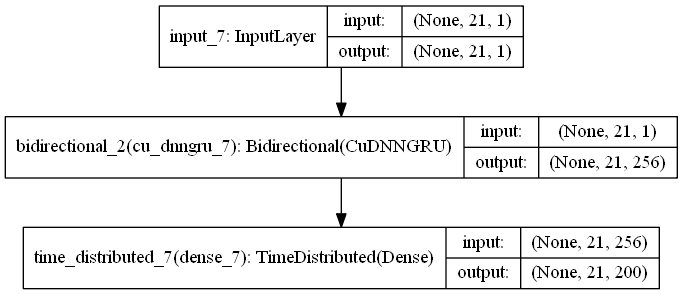

In [121]:
plot_model(bidir_rnn_model, to_file='bidir_rnn_model.png', show_shapes=True)

In [123]:
history3 = bidir_rnn_model.fit(tmp_x, tmp_y, batch_size=test_batch_size, epochs=30, validation_split=0.2, callbacks=callback_list)

Train on 93744 samples, validate on 23437 samples
Epoch 1/30
93744/93744 [==============================] - 4s 37us/step - loss: 0.9723 - acc: 0.7496 - val_loss: 0.4773 - val_acc: 0.8523
Epoch 2/30
93744/93744 [==============================] - 3s 29us/step - loss: 0.3816 - acc: 0.8749 - val_loss: 0.7032 - val_acc: 0.8013
Epoch 3/30
93744/93744 [==============================] - 3s 29us/step - loss: 0.3779 - acc: 0.8757 - val_loss: 0.3131 - val_acc: 0.8918
Epoch 4/30
93744/93744 [==============================] - 3s 30us/step - loss: 0.2866 - acc: 0.8997 - val_loss: 0.2724 - val_acc: 0.9026
Epoch 5/30
93744/93744 [==============================] - 3s 29us/step - loss: 0.2426 - acc: 0.9126 - val_loss: 0.2454 - val_acc: 0.9124
Epoch 6/30
93744/93744 [==============================] - 3s 29us/step - loss: 0.2283 - acc: 0.9172 - val_loss: 0.2476 - val_acc: 0.9114
Epoch 7/30
93744/93744 [==============================] - 3s 29us/step - loss: 0.2358 - acc: 0.9146 - val_loss: 0.2226 - val_acc

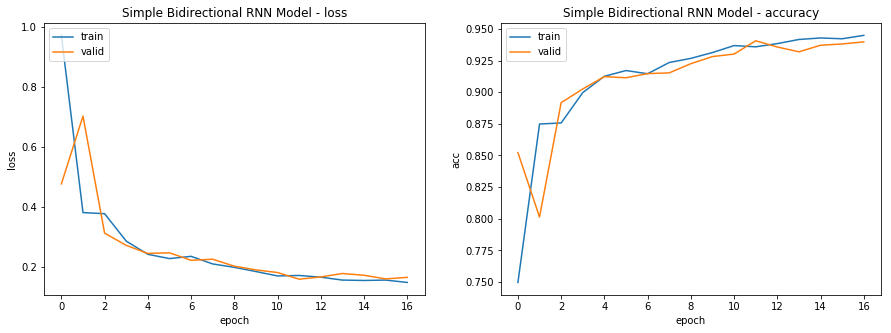

<Figure size 432x288 with 0 Axes>

In [125]:
plt.figure(figsize=(15, 5))
    
ax = plt.subplot(1,2, 1)   
# summarize history for accuracy
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Simple Bidirectional RNN Model - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

ax2 = plt.subplot(1,2, 2)
# summarize history for accuracy
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Simple Bidirectional RNN Model - accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.savefig('simple_bidir_rnn.png')

In [162]:
res_df3 = evaluate_model(bidir_rnn_model, x_test, y_test)

BLEU-1: 0.896982
BLEU-2: 0.853186
BLEU-3: 0.828067
BLEU-4: 0.773097


In [277]:
bleu_df.loc["bidir"] = [0.896982, 0.853186, 0.828067, 0.773097]

In [163]:
res_df3.head(10)

,from,target,predicted
0,californie est parfois sec au mois de mai et il est parfois merveilleux en fã©vrier,"[[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]]","[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, october]"
1,californie est jamais chaud pendant l' automne mais il est jamais sec en mars,"[[california, is, never, hot, during, autumn, but, it, is, never, dry, in, march]]","[california, is, never, warm, during, autumn, but, it, is, never, dry, in, march]"
2,les ã©tats unis est parfois pluvieux en janvier mais il est doux en mai,"[[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]]","[the, united, states, is, sometimes, rainy, during, january, but, it, is, wet, in, may]"
3,ils aiment les pommes les oranges et les poires,"[[they, like, apples, oranges, and, pears]]","[they, like, apples, oranges, and, oranges]"
4,il n'aime les mangues et les fraises,"[[he, dislikes, mangoes, and, strawberries]]","[he, dislikes, grapes, and, pears]"
5,le pamplemousse est son fruit prã©fã©rã© mais le citron est votre favori,"[[the, grapefruit, is, her, favorite, fruit, but, the, lemon, is, your, favorite]]","[the, grapefruit, is, his, favorite, fruit, but, the, lemon, is, your, favorite]"
6,l' inde est parfois agrã©able au cours de l' automne mais il est gã©nã©ralement agrã©able en mars,"[[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, nice, in, march]]","[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, nice, in, march]"
7,votre fruit le plus aimã© est la pomme mais son plus aimã© est la pãªche,"[[your, most, loved, fruit, is, the, apple, but, his, most, loved, is, the, peach]]","[your, most, loved, fruit, is, the, apple, but, his, most, loved, is, the, strawberry]"
8,les ã©tats unis est froid pendant l' hiver et il est parfois relaxant en juin,"[[the, united, states, is, cold, during, winter, and, it, is, sometimes, relaxing, in, june]]","[the, united, states, is, chilly, during, winter, and, it, is, sometimes, wonderful, in, june]"
9,i comme le pamplemousse les pommes et les mangues,"[[i, like, grapefruit, apples, and, mangoes]]","[i, like, grapefruit, peaches, and, grapes]"


#### observation:
The bi-directional model is a significant improvement on the previous models, in that there are no more duplicated words, so that the translated sentence reads better. Although there are still some errors in the individual word translations, especially when it comes to fruits and months, the model does a good job in correctly translating consecutive words, as shown by BLEU-4 score of 0.773, which is a considerable improvement over the embeddding model of 0.608 and basic model of 0.508.

### Model 4: Encoder-Decoder

In [129]:
num_rnn_units= 128
learning_rate = 0.01
test_batch_size = 512
embedding_dim = 128

In [130]:
def encdec_model(input_shape, max_sequence_length, input_vocab_size, output_vocab_size):
   
    input_seq = Input(input_shape[1:])
    encoded = CuDNNGRU(num_rnn_units)(input_seq)
    repeater = RepeatVector(max_sequence_length)(encoded)
    decoded = CuDNNGRU(num_rnn_units, return_sequences=True)(repeater)
    output = TimeDistributed(Dense(output_vocab_size, activation="softmax"))(decoded)
    model = Model(input_seq, output)
    print(model.summary()) 
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model    

In [200]:
modelcheckpoint = ModelCheckpoint(filepath=out_dir+"/encdec.{epoch:02d}.hdf5", monitor="val_loss", save_best_only=True)

earlystopping = EarlyStopping(monitor="val_loss", patience=5)

tensorboard = TensorBoard(log_dir="log_dir", histogram_freq=1)

callback_list = [earlystopping, modelcheckpoint]

In [201]:
# Reshaping the input to work with a encoder decoder model
tmp_x = pad(x_train, max_input_seq_length)
tmp_x = tmp_x.reshape((-1, x_train.shape[1], 1))
tmp_x.shape

(117181, 21, 1)

In [202]:
# Train the neural network
encdec_rnn_model = encdec_model(
    tmp_x.shape,
    max_seq_length,
    input_vocab_size+1,
    output_vocab_size+1)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 21, 1)             0         
_________________________________________________________________
cu_dnngru_13 (CuDNNGRU)      (None, 128)               50304     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 21, 128)           0         
_________________________________________________________________
cu_dnngru_14 (CuDNNGRU)      (None, 21, 128)           99072     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 21, 200)           25800     
Total params: 175,176
Trainable params: 175,176
Non-trainable params: 0
_________________________________________________________________
None


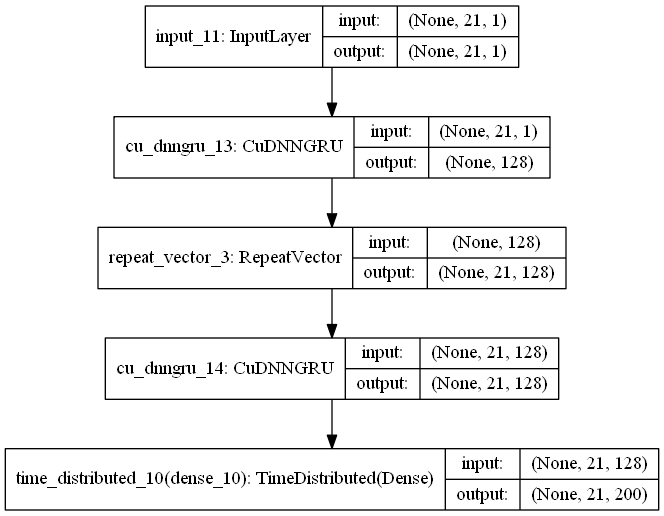

In [203]:
plot_model(encdec_rnn_model, to_file='encdec_rnn_model.png', show_shapes=True)

In [204]:
history4 = encdec_rnn_model.fit(tmp_x, tmp_y, batch_size=test_batch_size, epochs=50, validation_split=0.2, callbacks=callback_list)

Train on 93744 samples, validate on 23437 samples
Epoch 1/50
93744/93744 [==============================] - 4s 46us/step - loss: 1.8899 - acc: 0.5738 - val_loss: 1.3959 - val_acc: 0.6460
Epoch 2/50
93744/93744 [==============================] - 3s 29us/step - loss: 1.1656 - acc: 0.6775 - val_loss: 1.0271 - val_acc: 0.6994
Epoch 3/50
93744/93744 [==============================] - 3s 29us/step - loss: 0.8946 - acc: 0.7273 - val_loss: 0.7640 - val_acc: 0.7584
Epoch 4/50
93744/93744 [==============================] - 3s 29us/step - loss: 0.8094 - acc: 0.7491 - val_loss: 0.9681 - val_acc: 0.7208
Epoch 5/50
93744/93744 [==============================] - 3s 29us/step - loss: 0.7050 - acc: 0.7675 - val_loss: 0.9211 - val_acc: 0.7298
Epoch 6/50
93744/93744 [==============================] - 3s 29us/step - loss: 0.6672 - acc: 0.7746 - val_loss: 0.6302 - val_acc: 0.7834
Epoch 7/50
93744/93744 [==============================] - 3s 29us/step - loss: 0.6955 - acc: 0.7688 - val_loss: 0.7105 - val_acc

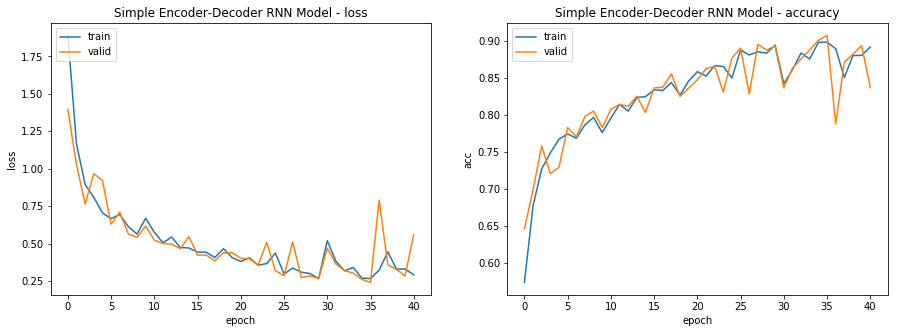

<Figure size 432x288 with 0 Axes>

In [205]:
plt.figure(figsize=(15, 5))
    
ax = plt.subplot(1,2, 1)   
# summarize history for accuracy
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Simple Encoder-Decoder RNN Model - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

ax2 = plt.subplot(1,2, 2)
# summarize history for accuracy
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA4IAAAFNCAYAAABVKNEpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAIABJREFUeJzs3XdYVFf6wPHvO/TeFBAUsXdUbDHFaDTF9GLUxPSebJLdlN3N7ua3m2ST3Wzapvdk00wxRtObJsaSYu/YK6iAgiggfc7vj3uRAenOMCjv53l4GG49lzvD4b3nnPeIMQallFJKKaWUUm2Hw9sFUEoppZRSSinVsjQQVEoppZRSSqk2RgNBpZRSSimllGpjNBBUSimllFJKqTZGA0GllFJKKaWUamM0EFRKKaWUUkqpNkYDwTZCRKaIyPceOvZbIvKwJ47dEkRku4iM83Y53E1EkkXEiIivt8vSGjX2vh/t7/FY/3wodSzQOq5uWse1TS1Vx6ljmwaCxxEROVlEfhGRAyKSKyI/i8gwAGPMVGPMGd4uY032H59CESlw+fqTt8t1NETkJxEpFpF8ETkoIktF5D4RCfB22Y6GiDwgImX2Pcqz32sjXdaPtu/nCzX2WyAi19ivr7G3+WONbTJEZHQd533L3uf8Gsuftpdf46ZLVEq1YlrHtQ5ax2kdp44fGggeJ0QkHPgSeA6IBhKBB4ESb5arkQYaY0Jdvh7zdoEao4GnZ7cbY8KADsA9wGTgaxGRFincUarn2j4yxoQC7YA5wMc11hcCV4lIcj2HzwX+bL9nG2sjcHWN8l0KbGnCMZRSxyit41qe1nFaxx0LtCXz6GggePzoCWCM+cAYU2GMKTLGfG+MWQWHn1ItqNzYfsp0m4hssp/q/VNEuonIr/YTvmki4m9vO9p+mvVXEdlndzeYUldBRORcEVnh8kQtpTkXZD+dmyYi79hlXCsiQ13WdxKRGSKyV0RyROR5e7lDRO4XkR0ikm3vH+Gy35X2uhwR+VuNczrsJ5tb7PXTRCTaXlfZfeJ6EdkJ/NjQNRhjCo0xPwHnAyOBcxo6j72+8sl3noikuzxtjLCvZ699DfeLiMNe5yMiT9j3aGvluVyOGSEib4jIHhHZJSIPi4iPve4asZ6u/1dEcoEHGriucmAqkCgi7V1W5QFvAf+oZ/d1wK/AXQ38+lx9AZwkIlH2z2cBq4BMl+vzyH13NxG5UUQ2i9Wi8bmIJNjLxf79Z4vV4rFKRPrb684WkTT7c7BLRO71RNmUasW0jtM6Tuu4VljHicg5IrLc/lyli8gDNdbXda+DRORJu8wHxGpZDar8PNY4xuFurvbnZrqIvCciB4FrRGS4/dnOs+//85Wfb3uffiIyS6x6N0usz3q8iBwSkRiX7YbY7z0/d/xujgUaCB4/NgIVIvK2iIx3+WNSn7OAIcAJwJ+AV4EpQCegP3CZy7bxWE/IErGeWr0qIr1qHlBEUoE3gZuBGOAV4HNpfpeR84EPgUjgc6CyIvTBejq8A0i2y/Whvc819tcYoCsQ6rJfX+Al4EogwS5jR5fz3QlcCJxqr98PVOsGYq/rA5zZ2IswxuwElgCnNHQeEUkCvsF68t0eGASssPd7Doiwr+tU4CrgWnvdjcC5wGBgKDChRjHeBsqB7vY2ZwA3uKwfAWwFYoFH6rse+w/sVUCOXXZXjwCX1Pb+cPF/wF1NqIiKse7/ZPvnq4B3amxzDZ6970dNRE4D/g1MxHqSvoOq9+0ZwCisf3gjgUlYv1+AN4Cb7Sfw/WnEP2hKHWe0jtM6Tuu41lnHFdrljcQKzm8VkQvtctV3r5/A+nyeiNXK/yfA2chzXgBMt885FajACrzbYT2QGAvcZpchDJgNfIt17d2BH4wxmcBPWPVxpSuAD40xZU24/mObMUa/jpMvrD/cbwEZWH8MPwfi7HXXAAtctjXASS4/LwX+7PLzk8DT9uvR9vFCXNZPA/7Pfv0W8LD9+iXgnzXKtQE4tY4yG+Ag1lO2yq8z7XUPALNdtu0LFNmvRwJ7Ad9ajvkDcJvLz72AMsAX+DvWh7xyXQhQCoyzf14HjHVZ38Fl32S7vF0buA8/ATfUsvxD4LVGnOcvwMxa9vfB6gbV12XZzcBP9usfgVtc1p1hl9cXiLP3DXJZfxkwx+X9sbOB63rA/l3lYf3RzQFGu6wfDWTYrx/D6mIDsAC4pub70H4P/cd+neF6rBrnfQt4GDgZ6ylrBJAFBNU4tqfv+xHvtUZ+Lt+i6vPxBvCYy7pQ+zzJwGlY/+yeADhqHGOnfa/D3fk3Q7/061j6Quu4yu20jjNax3ngvjerjqvlep4G/mu/ruteO4AirG7TNdcd/j27LNvuci0PAPMaKMMfKs9rvw+W17HdJOBnl/dfJjDcHb+HY+VLWwSPI8aYdcaYa4wxHbGediZgfSDrkuXyuqiWn0Ndft5vjCl0+XmHffyaOgP32M3zeSKSh/X0tbZtK6UaYyJdvr5zWZfp8voQEChWf/BOwA5jdd+oKcEun2tZKyuKBCC9coV9TTku23YGZrqUfR1WhRDnss3h/UXkZalKAPDXeq4RrCe6uY04TydqHxfQDvCv5doSXa47vcY61+vyA/a4nPMVrCejR1xXPaYZYyLtcq7BeppXm/8AZ4rIwHqO9XesJ4fxjTgvxpgFWE8U7we+NMYU1djE0/f9CGJlKqy8/9804jKqldEYU2CXI9EY8yPW090XgCwReVWqxphcApwN7BCRueKSwECptkLruMO0jqta53pdWsdVHavF6jgRGSEic+wulQeAW7DuJdR/rwPrWNcY1e6liPQUkS9FJNPuLvqvRpQB4DOgr4h0BU4HDhhjFjWzTMckDQSPU8aY9VhPmfq76ZBRIhLi8nMSsLuW7dKBR2pUesHGmA/cVA7X8yRJ7YOEd2P90XMtaznWPwF7sP4oACAiwVhdKFyPO75G+QONMbtctjGHXxhzi6lKAPCvugorIp2wKpT5jThPOtCtlsPsw3qCV/PaKstW7drsda7XVQK0czlfuDGmX23X1RBjzD6sJ7UPiEiHWtbnYP2D9s96jrEemAE09M+Fq/ewEhPU7DIDnr/vtV3DVJf7P74R5a9WRvszFYN9D40xzxpjhgD9sLqI/tFevtgYcwHWPzWfYj1pVqrN0jpO6zi0jmstddz7WK3znYwxEcDLQGXSoPrudXEd6wqBYJdr8cEKkKsVrcbPLwHrgR7GmHCs33lDZcAYU4xVn07B6lb7bm3bHc80EDxOiEhvEblHRDraP3fCag7/zY2neVBE/EXkFKx++jWzaQG8BtxiPyESEQkRayBxmBvLAbAI6w/fo/Y5AkXkJHvdB1h987uISCjWk6GP7Cer04FzxRq87A88RPXPwcvAIyLSGUBE2ovIBc0tpIgEi8ipWE+dFgFfN+I8U4FxIjJRRHxFJEZEBhljKrD+YD0iImH2vndjVRzY6+4UkY72+Jn7KsthjNkDfA88KSLhYg0c72aXrVnsSu47rH79tXkKq+9/n3oO8yDW+I/IRp72WayndvNqWddq7ns93geuFZFBYo0p+hew0BizXUSG2Z8bP6yKsBhrTJS//VQ2wljjFg5iPclVqs3QOk7rOLSOazX3vYYwINcYUywiw4HLXdbVda+dWGNtnxKRBLESAY2068WNWC3j59j14f1AQ2Nww7DqxgIR6Q3c6rLuSyBeRP4gIgH2e2uEy/p3sLr0nk/Ve63N0EDw+JGPNRB6oYgUYlWOa7CeLLlDJtbg4t1YH+xb7D+S1RhjlmAN6H7e3n4z1gesPiul+hxL9XX1qTxPBXAe1qDfnVj97yfZq9/EeqozD9iG9Q/1HfZ+a4HfYf1Dvscuo2t2qmewnmx9LyL5WL9H1z8YjfW8vX8W1lPDT4Cz7D9+9Z7HWIPuz8a6d7lYA6sru5/cgRUkbMUaO/C+fb1g/YPyHbASWIb1JNLVVVjdbtLs656ONU7gaDwO3CQisTVXGGMOYo2jqHOwvDFmG9a9Cqlrmxrb5xpjfjDG1PZktzXc94bK/wNWEoFP7HJ0oyo5QDjWPdyP1eUnB2swPVhPKreL1eXlFqwB7Uq1JVrHaR2ndZz373ttbgMeso/7d1x6rDRwr+8FVgOL7XX/wRoff8A+5utYrcGFNa6lNvdiBaD5WO+Tj1zKkI8VXJ+H9TnfhJVwp3L9z1hJapYZY7Y39eKPdVL7e02pKmJNgvqescZlKKWUUscNreOUattE5EfgfWPM694uS0vTSRiVUkoppZRSbY6IDANSsaakaHO0a6hSSimllFKqTRGRt7HmGPyD3YW0zdGuoUoppZRSSinVxmiLoFJKKaWUUkq1MRoIKqWUUkoppVQbc1wli2nXrp1JTk72djGUUkp52NKlS/cZY2pOMqzqoPWjUkq1HY2tI4+rQDA5OZklS5Z4uxhKKaU8TER2eLsMxxKtH5VSqu1obB2pXUOVUkoppZRSqo3RQFAppZRSSiml2hgNBJVSSimllFKqjTmuxgjWpqysjIyMDIqLi71dFI8LDAykY8eO+Pn5ebsoSimlWjmtH5VSqm077gPBjIwMwsLCSE5ORkS8XRyPMcaQk5NDRkYGXbp08XZxlFJKtXJaPyqlVNt23HcNLS4uJiYm5riu5ABEhJiYmDbxZFcppdTR0/pRKaXatuM+EASO+0quUlu5TqWUUu7RVuqNtnKdSinVFG0iEPSmvLw8XnzxxSbvd/bZZ5OXl+eBEimllFLep/WjUkp5lwaCHlZXRVdRUVHvfl9//TWRkZGeKpZSSinlVVo/KqWUdx33yWKaIu9QKb4OB6GB7vu13HfffWzZsoVBgwbh5+dHaGgoHTp0YMWKFaSlpXHhhReSnp5OcXExv//977npppsASE5OZsmSJRQUFDB+/HhOPvlkfvnlFxITE/nss88ICgpyWxmVUkqplqb1o1LK47LWgsMP2vf0dklaJW0RdJF5oJj9h0rdesxHH32Ubt26sWLFCh5//HEWLVrEI488QlpaGgBvvvkmS5cuZcmSJTz77LPk5OQccYxNmzbxu9/9jrVr1xIZGcknn3zi1jIqpZRSLU3rR6WUxxzcAzNvhZdOhJk3ebs0rVabahF88Iu1pO0+WOf6orIKBAj082n0MfsmhPOP8/o1evvhw4dXS1/97LPPMnPmTADS09PZtGkTMTEx1fbp0qULgwYNAmDIkCFs37690edTSimlGtJQ/dgcWj8qpVpcWTH8+jzMfwqcZRCZBAcyvF2qVktbBF0IYDx8jpCQkMOvf/rpJ2bPns2vv/7KypUrGTx4cK3prQMCAg6/9vHxoby83MOlVEop5WkicpaIbBCRzSJyXy3rO4vIDyKySkR+EpGOLuuuFpFN9tfVLVtyz9D6USnVbMZA2mfwwjD48Z/QbQz8biEMvBwK90GF/m2oTZtqEWzoyWR67iEKS8vpHR/utnOGhYWRn59f67oDBw4QFRVFcHAw69ev57fffnPbeZVSSrVeIuIDvACcDmQAi0Xkc2NMmstmTwDvGGPeFpHTgH8DV4pINPAPYCjW88ul9r77m1ueprTcuYvWj0opt9izCr79C+xYALF94arPoOtoa11YHGCgMBvCE7xYyNapTQWCDfFxCOUV7m0TjImJ4aSTTqJ///4EBQURFxd3eN1ZZ53Fyy+/TEpKCr169eKEE05w67mVUkq1WsOBzcaYrQAi8iFwAeAaCPYF7rJfzwE+tV+fCcwyxuTa+84CzgI+aIFyu43Wj0qpo1J8EGb9Hyx9G4Ki4JwnIfUa8HEJb0Ljre/5mRoI1kIDQRe+DsFpDE6nweFw3+Sz77//fq3LAwIC+Oabb2pdVznOoV27dqxZs+bw8nvvvddt5VJKKeU1iUC6y88ZwIga26wELgGeAS4CwkQkpo59Ez1XVM/R+lEp1SzlJfDh5bDjFzjhVjj1T1YwWFOY/YCpIKtly3eM0EDQhY+PFfxVuDkQVEoppWqorZKp2SXlXuB5EbkGmAfsAsobuS8ichNwE0BSUtLRlFUppVoPpxNm3gzb57Mk9VFWhZ5FycJcSsr3UlLupKTMSUl5BSXlToKL9vEQ4DyYqYlRaqGBoAtfh/UWKXc68dO3i1JKKc/JADq5/NwR2O26gTFmN3AxgIiEApcYYw6ISAYwusa+P9U8gTHmVeBVgKFDh3o6F5pSSnmeMfDtfbB2JnOS7uDaX5Jw7VHv7+MgwNeBv6/13U8EpxFmzFvKqN6XERsW6L2yt0IaCLrwtVsBy51aXyqllPKoxUAPEemC1dI3GbjcdQMRaQfkGmOcwF+AN+1V3wH/EpHKflBn2OuVUm1Z5hrwD4bort4uiecs+C8seoVDQ27mtkUncU5KHP+6cAABfg78fRy19ugr/lcU5Qf2cPYzC3jussGM7BZTy4HbJm32cuHjqOoaqpRSSnmKMaYcuB0rqFsHTDPGrBWRh0TkfHuz0cAGEdkIxAGP2PvmAv/ECiYXAw9VJo5RSrVh710CL4yA+U82e7qEXzbv4+Ml6Q1v6A3Lp8IPD0L/CTxurqS0wnDvGb2ICPYj0M+nzmFdgVEJnNPVQXiQL1Ne/40X5mzG6Y3/9VvhFBYaCLrQFkGllFItxRjztTGmpzGmmzGmMsj7uzHmc/v1dGNMD3ubG4wxJS77vmmM6W5//c9b16CUaiUKsqEg08qS+cND8MY4yEpreD8XXy1M45e3/sqOT/9JUWmFhwraTBu/h8/vgK6j2T3mKaYuzGBCake6tAtpcFdC4wgr3cfnt5/MuSkJPP7dBq59azG5haUeL/Zh676ARztZ11EPY1o2BtFA0IWPBoJKKaWUUupYk20HfRc8B5e+DXnp8MoomPsYVJTVv++BXaT973ZO/XoM9/p+xF0+01izbXf9+7SkjCXw8dUQ3x8mvcdzc3dgMNwxtnvj9g+Lh4IsQgN8eWbyIB65qD+/bsnhnGfns3RHC3SmWPspfHwNlB2CTXUHgrPSspj06m/kFzdwv9xIA0EXIoKvw0FFhdNrZQgNDQVg9+7dTJgwodZtRo8ezZIlS1qyWEoppZRXaf2ojlsH98D062H/9uYfo7L1L7Yv9LsQfrcI+p4Pcx6B18ZYk67XtHcj5tPbqHg6hZ7bp7Im9CTyT/4/fMSQse635pfFnfZtgqmXQmgsTJnO9nwH05ZkcPnwJDpGBTfuGKFx1vQRTiciwpQRnZlx24n4+TiY9MpvvD5/q+da4lZPh+nXQeJQSEiF3ctq3eyrVXu49b2llJRV4GzBMEQDwRp8HNIqWgQTEhKYPn26t4uhlFJKtSpaP6rjSkkBvD8R1kyHDbXPndko2WkQ3M4KmABCYmDCmzBpKuRnWcHgnH9BeSmkL4YPp2BeGE75qum8W3Ya/+r+PkPunk7YiCsBKN3ZCh6oHNwD714M4oArZkBoLM/8sAk/H+F3pzWyNRCsFkFnORRVtf71T4zgiztOZmyfWB7+ah0fLPLAuMiVH8GMGyHpBLjiE0g+CTJXW/fAxYxlGdzxwTIGJ0Xy3g0jiAj2c39Z6qCBYA2+bg4E//znP/Piiy8e/vmBBx7gwQcfZOzYsaSmpjJgwAA+++yzI/bbvn07/fv3B6CoqIjJkyeTkpLCpEmTKCoqclv5lFJKKW/Q+lG1ec4K+OR6TNYaSiSQbat/aX7Cwuw0iOt75PI+58LvFkL/CTD3P/BUb3hjHGb7An5ofxUjDj3DtmH/4P4pZ+Hn44CwOPJ82xOxf3WLj1er5lAuTJ0Ah3JgyscQ042NWfl8umIXV5+Y3LRpIELtSeXzM6stjgjy4+UrhtA9NpSvVru5K+yK9625DpNPtsofEGq1CFaUQvbaw5t9sGgn93y8khO6xvD2dcMJC2y5IBA0EDyCr4+4NWvo5MmT+eijjw7/PG3aNK699lpmzpzJsmXLmDNnDvfcc0+9H7aXXnqJ4OBgVq1axd/+9jeWLl3qtvIppZRS3qD1o2rTKufD2/gty/r9lV/Le1GUvpILXljA4u1NHLfmdEL2eqtbaG2Co+HiV+CyjyBhMOWnP8zdiVO5If1MrjgtlQfO71ct42Z+TAq9KzazPefQUVzgUSg+YGVA3bcRJr8HiakAPPX9RkL8fbllVLemHa8yECzIPGKViDC2TywLt+Zy0F1j85a9A5/eBl1HW79zfzuhjX0d7LK6h7718zb+MmM1p/Zsz5vXDCPYv+Vn9Wtb8wh+c5/VJFuP+PIKq0WwsTcjfgCMf7TO1YMHDyY7O5vdu3ezd+9eoqKi6NChA3fddRfz5s3D4XCwa9cusrKyiI+Pr/UY8+bN48477wQgJSWFlJSUxpVNKaWUaoxG1I9NpvWjUnX77SVY9CqMvJ2Xs8Zwsn8ao5yfcyC/kEtf/pXzByZw3/jeJEQGNXio3Ts2kFBWyFMrffli7U90ax9K91jrq0dsKN1iQwkN8IVeZ3Goyzhufncp8zft4/5z+nDDKUfOORiYPIz2WT/w2aZtdGnX3xNXX7eSApg6ETJXwaT3oNtpAKzOOMC3azP5/dgeRIX4N+2YYZUtglm1rh7XJ45X5m5l3sa9nJuScDSlhyVvwpd3QfdxVrdcP5eWy8jOEBQNu5fx8tzRPPrNek7vG8fzlw8mwNfn6M7bTG0rEGwEEeshjcEg1D4fSVNNmDCB6dOnk5mZyeTJk5k6dSp79+5l6dKl+Pn5kZycTHFxcQPlck9ZlFJKqdZC60fVJq37Er77K/Q+l6LRDzD/4dmM6zYIx/YZfH9lHC+tD+GVuVuYlZbFraO7cdOorgT6VQ8UDhSV8fXqPcxYlkHkzlm85g+5od3pHRnG5uwC5m7MpqyiqjW9Q0Qg3WNDySkoZX3mQR67JIWJwzrVWryYHiNhIeRsWggjPRMIfr5yN8t37ucP43oSEWR3hywrgg8mQ8YimPA/6DX+8PZPfL+ByGA/bjilS9NPFmo/SKqlRRAgNSmKqGA/fliXfXSB4KLX4Ot7oedZMPEd8A2ovl4EkzCYnA2/8Wjues5N6cB/Jw2yuuR6iccCQRF5EzgXyDbGHPEuEpE/AlNcytEHaG+MyRWR7UA+UAGUG2OGuqVQ9TyZrHQgv4Q9B4romxCOr8M9N2by5MnceOON7Nu3j7lz5zJt2jRiY2Px8/Njzpw57Nixo979R40axdSpUxkzZgxr1qxh1apaMj8ppZRSzdWI+tETtH5Ubc6upfDJDVY3wYtfY8HmXIrLnHQbMBK2Q9C+NO4+fQqXDunIo9+s56lZG/locTp/O6cP4/rEMXfjXmYuz2D2umxKy510ax/CPT2LYDs8fOMECAgDoKzCyc7cQ2zOLqj2daCojBcuT2X8gA51FtGROMj6vnsZcL3bfwUHDpXxt5mryS8u57s1mTw5cRAjO4fCh1Ng+wK4+FUr86lt8fZc5m7cy33jezdvDJ1/MASE19ki6OMQxvSK5ccN2VQ4zeHp5Jrk1xes4L7XOXDpW+B7ZKulMYZfi5MYUfgjlw2K4eGJg5t3LjfyZIvgW8DzwDu1rTTGPA48DiAi5wF3GWNcO0WPMcbs82D5alU5qXxFhcHXTQF6v379yM/PJzExkQ4dOjBlyhTOO+88hg4dyqBBg+jdu3e9+996661ce+21pKSkMGjQIIYPH+6egimllFJepPWjalP274D3J0Noe7jsQ/APZnbaZsICfEkZMBi+DbG6RDKFTtHBvDAllSu25PDgF2u5beoyAv0cFJc5iQ7x5/LhSVycmsiAxAhk+ttWt0M7CATw83HQrX0o3dqHcma/JpYzKJLcoCQSCtaRX1zm9gQmr83fSn5xOY9dksJLc7dw1esL+CruNXrmzYfzn4OUiYe3Ncbw+HcbaBcawFUjOzf/pKFxdbYIAoztE8eM5btYtnM/w5KjG39cY6wpOuY9zv7ks9k07ClKtx2krMJpfxnKnU5Ky50s3p5L7rZoTvQ3PHKCqTYu01s8FggaY+aJSHIjN78M+MBTZWkKX5+qSeUDGti2KVavrhp70a5dO3799ddatysoKAAgOTmZNWvWABAUFMSHH37oxtIopZRSrYPWj6pNKMqzpomoKIFrvoTQWCqchh/WZzG6dyz+/n4Q1++Isboju8Xw1Z2n8OHinaxKP8AZ/eIY1bN99e6E2WnWvm5UHjeIlEPzWZGexyk92rvtuDkFJbz58zbOSenAxGGdOHdAe7a+fBk98+bzfOAtjIm/ANcrWbB5H4u25fLAeX2PLplKWHydLYIAp/Rsh69DmL0uq/GBoLMCvroHlv6P7wPO5Jb1l+NcX3/CqjuHj4ZVT+LYsxySRzbhAjzD62MERSQYOAu43WWxAb4XEQO8Yox5tZ79bwJuAkhKSjrq8lQ20bozc6hSSimllGqjykth2lWQswWunAHtewGwIn0/+wpKOb2vncykQwqsmma1MrmMffVxWJOgTxlR27FLrEnXe5/j1iKHdxtB4PbP+WLjRrcGgi/9tIXisgruGtcTnBUEf30n/fN+ZPPgv/D2mqE888LP3H16L24a1RWHwBPfbSAxMojLRhzl//ihcbCr7rkRwwP9GNE1mh/WZfOX8X0aPl55Ccy4CdI+JXvgbdy08CRuHtWNU3u2x9fHgZ+P4OfjwM/Hga+P4O/jIMjfh3ahAbAtoc6J5Vua1wNB4Dzg5xrdQk8yxuwWkVhgloisN8bMq21nO0h8FWDo0KFHHb1Vdg1tDZPKK6WUUkqpY9z3f4Ntc+HCl6DLqKrFaVn4OoRTe9qBVvwAWPw65O2AqOTGHXvfJjAVdU8d0UyBnYcBULhtMXCSW46ZeaCYd3/bwUWDO9K9XTB8+XtY9RGcdj/dR/2R78eV8teZq/nPt+v5cX0W5wzowMqMA/znkgFHn1WzskWwRpDtamzvOB76Mo0dOYV0jgmp+1glBfDRFbB1DpzxME9njSbQL4PbxnSvSnxTn8TUw1NIeFtrmEdwMjW6hRpjdtvfs4GZQIt1+vexE8SUO50tdUqllFJKKXU8qiiD5VNh4OUw6PJqq2alZXFC15iq4CF+gPW9KVO5ZKdZ393cNZT4AVTgQ/DelTjd1Djy/JxNVDgNvz+tuzWH4rJ3YNQfrS8gKsSfF6ek8tTEgazfk88DX6RHwHlXAAAgAElEQVSRHBPMJakdj/7koXFQXgQlB+vcZFwfq2X2h3XZdR/nUC68cz5smwcXvEjhkFv5fMVuzh7QoXFBIEDCYMjdYnUX9jKvBoIiEgGcCnzmsixERMIqXwNnAGuO5jz1TUZbk0PAIe6dVL6lNOU6lVJKqbZSb7SV61St0O7lUFYIPc+stnjL3gK27i2s6hYKVqueOGBPE7LfZq0Fhx/EdHdTgW3+weSHd6e3cxObsguO+nDpuYf4aHE6k4Z1ImnV07DoFRh5O4z5W7XtRISLUzvyzR9O4aLBifzrogH4umN6hTB7Col6xgkmxQTTIzaUH9bXsc2BXfDmWZC5Bia9C4On8NWqPRSUlHPZ8CZ0Xa2cWH738sbv4yEeCwRF5APgV6CXiGSIyPUicouI3OKy2UXA98aYQpdlccACEVkJLAK+MsZ829xyBAYGkpOT0+hKQETwcQjlFcdWpWGMIScnh8DAwIY3Vkop1eY1tX48Vmn9qLxqmz2yKfmUaotnpVnBxjjXQNAvCNr1bGKL4DprHx/3ZvYE8Ok4hAGObSzbkdvwxg145odNiAh/jpgF8x6DwVfCGQ/X2U2zY1Qw/500iBO7tzvqcwNWiyDUmzkUrOyhC7fmcrC4rPqKfZvgzTPh4G5rnKc9JvODxTvpHhvK0M5RjS9LwmDreysYJ+jJrKGXNWKbt7CmmXBdthUY6K5ydOzYkYyMDPbu3dvofbIPFpPjEAqy3Jk31PMCAwPp2NENzedKKaWOe82pH49VWj8qr9k+H2L7QUhMtcWz0rLolxBOYmRQ9e3jU2DHL40/fnYaJJ3ghoIeKbTrcCTtfbZvXgsjmj91w5a9BcxYlsEzPVcTPu/f0PdCOO+ZOoNAj2hEiyDAuD6xvDx3C/M27q2aXD5nixUEigOu/Qo6WGHKhsx8lu/M4/5z+iBNuZagKIju2irGCbaGZDEe5efnR5cuXZq0z7/eWEh+cTmf/m6Qh0qllFJKeVdz6kelVBOUl8DOhTDk6mqL9+aXsGznfn4/tseR+8QPgNXTrLFowQ1MY1B8AA6kQ+y1bix0FbG7MJanLwHObvZx/jtrIxf6LeLcHc9A93Fw8WvgOMrkL03VyBbBwUlRRAX78cO67KpAMO1TOJQDty+BdlX37INFO/H3cXBxc8YwJqTCztqnymlJrSFZTKsTHeLP/kOl3i6GUkoppZQ6Vu1aaiUoqdEtdM76bIyh+vjASk1JGJO93voe6+ZEMZVi+1LuCCC+YB25hc37v3jdnoPkr/mWx32eR5JOgInvgq+/mwvaCIER4BsI+fUHgj4OYUyvWOZsyKa8wk4cmbvVCiRdgsDisgpmLt/FGf3iiA5pxvUkpsLBXQ22UHqaBoK1iAr2b/YbXimllFJKHR9Ky53NTyC4bT4gkFx9+oXv07JIjAyib4fwI/dpUiC41voe596pIw7z8aMoui8pjq0s37m/WYf47PNPeNn/v9C+D1z+EfgHu7mQjSRiBXMFDQdeY/vEkXeojOXpdlbP3G1WV04X367J5EBRWdOSxLhKqEwY493uocd919DmiAnxJ7+4nNJyJ/6+GisrpZRSSrUpxrB2zTLe+2QGX5WmEhIWSVx4IPHhgcRHBFqvIwKICw+kR2wY7cNqySuxfb4V2AVVJRIpKq1gwea9TBraqfZxZSHtICwBMhuROTQrDfzDIKLTUVxo/YKSh9F/79u8tGMfY/vU0oJZjw3L53Pb7r9QHBxP0FUzrVY5bwqLb7BFEGBUz3b4+Qiz12UxLDnaahHsdlq1bT5YtJOk6GBGdo2p4ygN6JBijTnctQx6jW/eMdxAA8FaRNlNvHmHSokN1yxjSimllFLHvZJ8K8vn5tmUb5xNv4M7+TdwTtcbmRl+JVkHi9m8t4CfN+8jv6T88G6Bfg6m33Ii/RNdAp2yYkhfBMNvrHaK+Zv2Ulzm5PS+8XWXI35AI1sE10FsH48mXfHtNATfJa+SuWUV0IQuqHs30uGLKRRKCOHXfQmh7T1WxkYLjYO96xvcLCzQjxFdYvhhXTZ/GdsZ8vdAVNV46q17C1i4LZc/ntkLh6OZv3v/EGjf2+tTSGggWIvKvr45hRoIKqWUUkodl5xOyFoNm2fD5h8h/TdwlmP8QlhCf2aZ0/lj3FJOLlnAyROfqLZrYUk5mQeL2ZNXzB+nr+S2qcv48s6TCQ+0p3HIWAQVJbVOGxEW6MuIrvUkgumQYpWprBj86vg/1Bira2jfC47mN9Awuwujf9YKyismNW5Ov/wsSv53PiUVhvkjX2di++ZnHHWrsHjYOrdRm47tE8uDX6Sxe/s6EgCiqwLBjxan4+MQLh1ylJmIE1Jh4zfWvWzJDKoutN9jLSoDwf06TlAppZRS6vhTUQbvXgivjIIfHoKSA3DiHTiv+oI7O8/gsoLfc/Jl9xE49ArYu85qfXMREuBLt/ahnNyjHc9fPpjdeUX86eNVVfNybptvdf3rPLLqlE7Dj+uzGdMrFr/6Aqr4AWAqrPPWJT8TivZbk9B7Ukx3ynxD6ePczPrM/EbtYn59Ab9DWdzt93+cP3aUZ8vXFKFx1n0uK2pw07G9rW6waWtWWAvsMYKl5U6mL81gbO/Yo28sShxsZSPN23l0xzkKGgjWojIQzNXMoUoppZRSx5/v/w+2zYVxD8I9G+GWBTDuAZ7dGs8Xa3L46/g+jOkdC33OBwTWflrnoYZ0jubPZ/Xm27WZ/O/n7dbCbfOgw6Bq4+KW7dxPTmFp7dlCXTUmYUx2mvXd04Ggw4EzfiADHVtYuqMRCWNKCihf/D++qRjKGePOJNCvhaeJqM/huQQbHieYFBNMj9hQsrbbv2e7RXD2uixyCkubnyTGVStIGKOBYC0OB4LaIqiUUkopdUwqq0z/X9Pq6bDwJTjhNjj5DxBmBWZfrdrD07M3MWFIR244xe4KGBYHySfD2plWF7463HBKF07vG8e/vl7Hii27rKkjuhzZLdTPRxjdq4HxcpHJVhKYPfUkjGmpQBDwTxpKH0c6K7c3nHGzZOlU/MoOMiv8EiYN9VwSm2YJtQPBRmQOBSt7KPu34wyMOpzw54NFO0mICGRUTzeMeYzrDz7+Xp1YXgPBWkQGWf27NRBUSimllDr2PPX9Bvr9/Tv+/tkasg4WV63IWguf3wFJJ8LpDx1evGbXAe75eAWpSZE8clH/6hk9+10I+zYc0T3UlYjwxISBxEcE8vaHH4GzDLpU7xY5Oy2LE7rGEFY5jrAuDgfE92+gRXCd1dUxpJlZK5tAElPxo5z8HQ0kNnE6KZj7HCucXbliwqWtL/O+HfA3pkUQYFyfWJLI5ECQFdCm5x5iweZ9TBzWCZ/mJolx5etvBYNeTBjTyu5Q6+Dr4yAiyE8DQaWUUkqpY8xr87by7I+b6d0hjPcX7mTUY3N45Ks0cvdlw4dTICAcLn0LfKyALDu/mBvfWUJ0sD+vXDmUAN8a3Rn7nG+N91s7o97zRgT78cLlqfQqXk45Pjg7jji8bnN2AVv3FTbcLbRSfApkrbES2tQma22LtAYC1uTnQHzBOrJdg+oati/8lJiSdNZ3vpKhXTwfoDZZE1sEBydF0dUnm60VsQBMW5KOABPd2dKZmAq7V9R9nz1MA8E6xITopPJKKaWUUm6VvgjeHA+FOR45/LTF6Tzy9TrOSenAzNtO4sd7RnNuSgJvLtjCyucmUZG3k4IL3jzcOlRcVsHN7y4l71AZr109tPb5AENjG9U9FGBgp0guid7GCmc3Xl2YfXj5rDQr+BjX2Ln44gdAaQHs33bkOmeFNQ1CSwWCEZ0oC4xhoGMry+qYWL7CaTjw49NkEc34ibe0TLmaKjgGHL6NbhH0cZbRgX0sORhJSXkF05akc2rP9iREBrmvTAmpUJoPOZvcd8wm0ECwDlEh/uzXZDFKKaU8RETOEpENIrJZRO6rZX2SiMwRkeUiskpEzraXJ4tIkYissL9ebvnSK9UMZUUw82bY+Qus/MDth/9m9R7um7GKU3u2578TB+HjEJJignly4kAWnbKCMbKMB0uvYOTUAp77YRMFJeX8dcZqlu/M46mJA+mXUM+E5/0ugpzNVitdfUryaXcwjb0xw3n8uw0s2pYLwKy0TPonhjc+iKgvYcz+7VBeDHEtFAiK4OiYykDH1joTxnw5azYDy1aS0/dqIsKCW6ZcTeVwQEhso1sEyduJAycbStvx1PcbyTpYwmR3JIlxZbe2emucoAaCdYgK9ienQANBpZRS7iciPsALwHigL3CZiNT8r+5+YJoxZjAwGXjRZd0WY8wg+6uVPn5Xqoaf/g25WyGsAyx/r8HWtaaYv2kvv/9wBalJUbx0RWr18WmbZhGz6ElImcTk2/7JCV1jeHLWRoY/MpsZy3dx9+k9GT+gQ/0n6HM+iI/VKlifHb8ipoJTz7yYTlFB3PHBMtZnHmR5eh6n96lnEvma2ve2Wq9qCwSz1lrfW6pFEPDpOJRusou123YdsS7zQDEVv7xAiQTQ59w7W6xMzRIW1/hAMHcrABmODrw6fyvtwwI4rXese8vTrif4hXgtc6gGgnWI0RZBpZRSnjMc2GyM2WqMKQU+BGrODG2AcPt1BLC7BcunlHvtWga/PAepV8Gpf7bmyHPTP79Ld+znpneW0i02lDeuGUawv2/Vytxt8MkNVlKOc5+mb2IEr101lE9/dxIju8YwZUQSd5zWveGThLSzkr801D10+zzw8Se424m8MCWV/YfKuOzV3zCGxo8PBGsi+Xa9ILOWzKHZaYBYwWJLSUjFgUEyV1FSXlFt1VMzF3AOCyjtNwkJjm65MjVHaDzkNy0QbNepN8bApUM61j//Y3M4fCBhkLYItjZRIf7sLyyrmhhUKaWUcp9EIN3l5wx7masHgCtEJAP4GrjDZV0Xu8voXBE5BaVas4oyK1NnSCyc/k/ofzH4BlmtgkdpfeZBrntrMXHhAbxz3XAiglwycpYegmlXAgYmvQP+VV0WB3WK5I1rhvHIRQOqZwitT7+LrOCgtuCs0rb50HEY+AXRLyGCB8/vx/5DZSRGBtGnQ1jTLi5+QO0tgtlp1rx2/i3YBdPuwtjXbGbNroOHF89OyyJu0wcESBlhp95R196tR1gcFDRujCC5W8E/jJMH9sHfx8GkYR6aDiNhsHWfy1u+AUoDwTrEhPhTWuGkoKTc20VRSil1/KntP8+aTx4vA94yxnQEzgbeFREHsAdIsruM3g28LyLhNfZFRG4SkSUismTv3r1uLr5STfDz09bYunOehKBIa5L1vhdY8/mVHmr2YXfkFHLlG4sI8vPh3etHVE/0Ygx8dbf1D/bFr0N016O/jj7n1d89tCjPChKTq57NTB7WiTtP685dp/dsfMBZqUMK5O+Bghqf36y0Fu0WCkBIOyrCOzHQsZXldsKYwpJyHv5sBdf6z8bZfRy079myZWqO0Hgo3AcVjfj/fv82iE5m8vAkFvx5DJ1jQjxTpoTBUFFSNTdkC9JAsA5R9qTy+wvLvFwSpZRSx6EMwPXxckeO7Pp5PTANwBjzKxAItDPGlBhjcuzlS4EtwBH/gRljXjXGDDXGDG3f3g2THyvVHHs3wNzHoO+F0OfcquWDr4CSg7D+y2YdNutgMVe8sZDyCifvXj+cTtE1WsfmPWElpDn1Puh5xlFcgIvgaOg6uu7uoTt+AeOsNpG8iHD3Gb2YMKRj089XmTAmy6VVsKwIcre0fCAI+HRMJdV32+GEMU/P3khq/o9EmzwcJ9zW4uVplrA4wEBhdoObkrsVorvicAix4YGeK1NlwhgvzCeogWAdokOsrgU5hSVeLolSSqnj0GKgh4h0ERF/rGQwn9fYZicwFkBE+mAFgntFpL2dbAYR6Qr0ALa2WMmVaiyn0+oS6hcMZz9efV3nkyAqGZa/2+TDFpdVcNUbi8gtKOWta4fTI86ly6Ux8OPDMOdhSJlkjUd0p34XWVk796w4ct32+eAbaHUNdYe4/tZ31+6h+zZawWZLZQx1lZBKgsli8/YdrNl1gDd/3sa94T9A+z7Q7bSWL09zVM4l2NAUEhXlsH+He1qSGxLVBYKivJIwRgPBOkSHWN0LNGGMUkopdzPGlAO3A98B67Cyg64VkYdE5Hx7s3uAG0VkJfABcI2xBq6PAlbZy6cDtxhjclv+KpRqwOLXIX0hnPWoNRcfYIwh71Cplcp/0BWwbZ4VWDXBi3M2syErnxevGMLATpFVK4yBWf8H8x6HwVfChS9Z53Gn3udY2Txr6x66bT50Gg6+tcxF2BzB0RDRCfa4jEnMsrsPxvZzzzmawm65Sji0njs+WM7YoM0kFG+CE26FpnZ79RZ7/sgGM4cezABnWcsEgiJW99Bd2iLYakQHW11Dc7VrqFJKKQ8wxnxtjOlpjOlmjHnEXvZ3Y8zn9us0Y8xJxpiB9jQR39vLPzHG9LOXpxpjvvDmdShVq7ydMPsB6DYWBk4GoLzCyZ8/WUXqP2cxb+NeGHQZILDi/UYfduveAl6eu5WLBidyak+XLs9OJ3zzJysz6bAb4LxnrYyM7hYcDV3HHNk9tDDH6sKZPMq956uZMCZ7LfgEtEyAUlOHQRiEFNnCtn2FPBg715qkPWViy5eluRrbIpi7zfoe1cWz5amUkGqNETyKMbPNoYFgHaJDKwNB7RqqlFJKKdVoxsAXf7Ben/c0iFBcVsEt7y1j2pIMwgL9+NP0VRzwi7O6FC6fCs6K+o+J1Zr498/WEuDn4C9nu0yd4HTCl3+ARa/CyNvh7Cfc3xLoqv/FVqDrmvJ/xwLrexc3J/GNT4GcTVUBQvY6KymLj2/9+3lCYDjE9GCI3zYmdCkjfs+PMPQ68Atq+bI0V2gsIA23CNpTR7RYwJ2YCqai9iyxHqSBYB1C/H3w93Foi6BSSimlVFOs/BC2/ADjHoDIJA4cKuPKNxbyw/osHrqgH+9eP5x9BSX84/M1VtKYgxmwbW6Dh/1q9R4WbN7HH8/sRWyYnbyjohw+uw2WvQ2n3ANnPOz5boq9zgaHH6ydUbVs23xrLGRCqnvPFT/AGhOYvc76OSvNO91CbZKYysnB6fw78WfE4Wu1vh5LfPysVswGWwS3WuM9wzq0TLkq3zctPE5QA8E6iAhRIX7aIqiUUkop1VgF2fDtfdDpBBh2A5kHipn4yq+sSM/jucsGc9XIZFI6RnLHaT34dMVuvikbYiXKaGBOwfziMh76Io3+ieFMGdHZWlhRBjNutLKDjrkfxv69ZcaqBUVC97Gw9tOq7qHb50PSCeDr795zVWYOzVwFRfshfzfE9nHvOZoiMRXfQ9n4LX8b+l8CYfHeK0tzhcU3okVwm9Ut1JMty67CO1hBZwtPLO+FduVjR3RIgLYIKqWUUkq5MgZK8qEoFw7lwKH9Va/XfwVlh+D859iSc4ir3lhE3iEru+dJ3dsdPsRtY7rx4/os/vrFBk5NuZjg1e9ZgU5QVK2nfHr2JvYWlPDqVUPxcQiUl8D066zpJ05/CE76fUtdvaXfRbDxW8hYAlGdYe96K0upu0UmQUCEFQi272Uti/Nei+DhlquKEitJzLEoNLbhFsH92yC6hcYHVkpIbfEWQQ0E6xEd4qdZQ5VSSimlAH57GRY8BYdyrYyKtREfOOvfrCiO5dr//YKPQ/jo5pH0T4yotpmfj4MnJw7inGfn85+sYTxY8YY1wfzwG484ZNrug7z1y3YuH57EoE6RUFYM066ETd/D+MdgxM2euNr69RoPPv5W0piOQ6xlXU51/3lEqhLGVM4d6IU5BA+LH2BlTe00AhIGea8cRyM03prfsi5Op9Ui2NJTYiQOhg1fQVGe1ercAjQQrEdUsD9rdx/0djGUUkoppbzLWQE/Pw1B0TDocmucVVC0lUUzKNr6OTgaAiOYtzmXW177jZhQf969bgTJ7UJqPWT32FDuG9+bB79I4/exfYhe/t4RgaDTabj/09VEBvnxpzN7Q2khfHCZNe3EuU/D0Gtb4uqPFBgB3cdB2qdQVgj+YdBhoGfOFT/AGgOZtcZqHQxP8Mx5GsMvECa8ac0deKwKi7O6hjqdtXf9LMiE8qKWbxEceBn0OBMCwhre1k00EKxHTIg/uYXaIqiUUkqptq1s68/45e/h4fIrWLpxDOGBfkQE+REe5Et4oB/hQUJ4YAEHi/fzxHcb6BEXxtvXDiM2PLDe4149MplZaVm8lH4Cfzv4P6vlq3JcHPDx0nSW7czjiUsHEuFTDO9NhPTfrDkCB13m6cuuX7+LYMPXsPIj6DLKc5k8O6RY3W03fGNNJO/tOfv6XuDd8x+t0HhwllvdmUPaHbm+pTOGVoroaH21II8FgiLyJnAukG2M6V/L+tHAZ4A9UQczjDEP2evOAp4BfIDXjTGPeqqc9YkK8edAURllFU78fDSvjlJKKaXanswDxaya/gInmQB2xIwiVHzJO1TKztxDHCwq40BRGeXOqjn1RnSJ5rWrhxIe6NfgsR0O4fFLBzLxv7v4E+/hs/w9HOP/A0BuYSn//mY9w5OjuaRvCLx7kZVM45LXrUQl3tbzLGtOv/Ii908b4aoyMC7Igt7neu48bUXlpPL5mXUEgnZo4o25GluYJ1sE3wKeB96pZ5v5xphq72gR8QFeAE4HMoDFIvK5MSbNUwWtS0yIlfkp71AZ7cMCWvr0SimllFJe9dvWHO6aupBvy+eT1/lMXrvuyAnTjTEUlVVwsKicgpJyurQLsRK6NFJiZBB3nz+Cbz8dwrhlHxJ0+kPgG8Bj364nv7icR85KRN65wJo6YeI70KeVBEOB4dDjdCthTbIHA8F2vazpKpxl3s0YeryonFS+IBM4oq3KahF0+EJ4y7bOeYPHmrmMMfOA3GbsOhzYbIzZaowpBT4EvNIGHWUHgpowRimllFJtiTGG1+dvZcrrCxnrv5oIKSTxlKtq3VZECPb3JT4ikO6xoU0KAitdnJrI1o4XEVSWx66FM1i6Yz8fLk7nzhHh9Ph6MmSvh8nvt54gsNJJf4BBV1Trzup2vv4Q29t67c2MoceLwy2CdUwhkbsVIjt7rqtvK+Lt/o4jRWSliHwjIpXv7EQg3WWbDHtZi4sOtgLBnAINBJVSSinVNhSWlHPHB8t5+Kt1nN4njn8kp1nJYLqO9tg5RYQrLruKTNqxe85r3P/pGgaEFXLHzj9Y/5hPmQY9z/DY+Zut0zC48AVw+Hj2PPEp1ndtETx61VoEa5G7tU10CwXvJotZBnQ2xhSIyNnAp0APoLbHSKaWZQCIyE3ATQBJSUluLWB0qLYIKqWUUqrt2LavkJvfXcLm7AL+fFZvbjmhPfLEdzB4Cvg0PObvaMSEB7O17yRS175IUOYS3o1+E0d+Llw5Azqf6NFzt3rDroeo5DrnWVRN4B8MAeG1twgaA/u3Q9LIFi+WN3itRdAYc9AYU2C//hrwE5F2WC2AnVw27Qjsruc4rxpjhhpjhrZv396tZaxsEdTMoUoppZQ6pq2ZAfs217na6TR8vzaT859bwN78Et65bgS3ju6GbPjGSoYy4NIWKWbXcTfiI4aPA/5JcHkeXPmpBoEAiUPg1D95uxTHj9C42lsED+VAycGWnzrCS7zWIigi8UCWMcaIyHCsoDQHyAN6iEgXYBcwGbjcG2WM1EBQKaWUUse6xW/AV3ezP6wX7w9+j32FZeQUlJJTWGJ/LyW3sJQKp2FAYgQvXZFKx6hga9/VH0NEEnQc3jJlje4C3U7DZ/dyKwg8VictV61bWHztLYLemjrCSzw5fcQHwGignYhkAP8A/ACMMS8DE4BbRaQcKAImG2MMUC4itwPfYU0f8aYxZq2nylkff18HYYG+GggqpZRS6ti0aTbm6z+SbmJJyt/AhtlvM8dvFDGh/sSEBtApOpjBSZHEhASQEBnExamJBPrZ490K98GWH+GkO2ufeNtTJr5jTWAfFNly51RtS2gc7Fpy5HINBN3DGFPvLJ/GmOexppeobd3XwNeeKFdTReuk8koppZQ6FmWtxXx8DTt8OnO5+TtzYv7DMxVfIrf/w8pE2ZC1M8FUtFi30MMCwlr2fKrtqWwRNAbEJT1J7jYQB0S6N+9Ia+XtrKGtXnSIvyaLUUoppdSxJT8Tpk6kSIKYXHAXt48fQsCZDyF522F5fVM8u1g9HWL76pQF6vgTGmeNfS05WH157lZr/kDftjF/uAaCDYgO1hZBpZRSSh1DSgvhg8mYolyuK72Hjp27M3lYJ2vy86QTYe5j1jb12b8D0n+DARNapsxKtaQwewqJmuMEc7e2mUQxoIFgg6K0a6hSSimljhXOCphxE+xZyRtx97O0NIl/XzwAh0OsLnDj/gEFWbDw5fqPs+YT63v/SzxfZqVaWqg9qXzNzKFtaA5B0ECwQTF2IGjlsVFKKaWUasVm/R3Wf8mW1L/x8OZkbj21Gz3iXMbcJZ0APcfDgmfgUG7dx1k9HTqNsOauU+p4U1uLYFEeFOVqIKiqRIX4U1Lu5FBphbeLopRSSqk2pqy8gp/mzaEgb1/DGy9+A359nvKhN3Hd+iF0bRfCbWO6H7nd2P+zxkYt+G/tx8laC9lrWz5JjFItpbYWwf3brO9tqGuo1+YRPFZEh1TNJRgSoL8upZRSSrWQHb+QM/1eRuevhR+hNKIL/knDIDHVmmA8fgD4BVnbbp4NX/8RepzJf32uYUfOdt6/cUTVVBCu4vpByiRY9CqMuAUiEquvXz0dxAf6XujxS1TKKwIjwDfQSqpUqY1NHQEaCDYo2p5Ufv+hUjpFB3u5NEoppZQ67u3bDLP/Aeu/REwUb4TfQlHBQfrkbeKk0rkErp5mbefwtbJ6JgyCNTMhri8bRj3DKy8tZ8KQjpzYrV3d5xjzF2sc4Nz/wPnPVi03xgoEu46G0PaevEqlvEfEahUscOkaWhkItqHu0BoINiDKbhHM0YQxSimllPKkwn1WYLbkTYxvIJ+EX82jB8bx1Y7k4P8AACAASURBVI1nUOE03PLeUq7POMBfTo7gxm55OHYvg11LIe0zCI3FOflD7nt/K+FBfvzt7D71nysqGYZdD4tegxPvgHY9rOXpi+DAThjzV49frlJeFRZfo0VwO4R1AP8QrxWppWkg2IAYOxDcr4GgUkoppTyhrMjK4jn/KSgtgCHX8H37a7l3ZjoPnNeXuPBAAKbdPJL/+3QN/16QwW97Y3l60l+ICPYDpxOAqQt3snxnHk9NHHj4QXa9TrkXlr0LPz4ME9+2lq2ZbnWZ632Op65WqdYhNA72rq/6OXcrRLWd8YGgyWKq2/Ct9STMRZTLGEGllFJKKbda/zU8PwxmPwCdT4Rbf+XA2Me4f3Y2AxIjuHJk8uFNA/18eGxCCv+8sD8LNu/j/BcWsCEzHxwOsgpKeezbDZzUPYaLBifWebpqQtvDibdD2qewaxlUlMOaGdDzLAgM98jlKtVqhMVXzxraxqaOAA0Eq/v6XquLhIvwQF98HaKBoFJKKaXcqyAbpl8LAeFw9Rfw/+zdd3jUVfb48fdJJ4V0II3ea4CABctipfgV0V0Fd62ruFZW3bWtq/5wXcvqquvasHdkFRUVRbChIpAAoYdOICRAIJX0zNzfH59JmIRUMpNJOa/nyTOZ+ylzZlfNnLn3nnP5h9BtME99s5UjR8v45/QReHtJjUtEhCtO7sW8WSdTXG7joud/4Yv1mTy0cBPlNjuPXDQCEannBetwyi3QJQK+nQO7f4Diw1otVHUOwd2hLN+akS8vsiqIdqKKoaCJYE1RA+DwthpDIkJ4kB+5xZoIKqWUUsohby98+7CVzJ2oFS9CZZm1LLPPGQCk7svjnRXpXHlKb0bEh9Z76dheEXx562kMje3KLe+v5auNB7jt7AH0jmrm/qaArnDGX2DX97D4fvAPhQHnnvh7Uqq9qO4leABy91i/64xgJxY1EA5vtypmOYkI9OPIUU0ElVJKuY6ITBKRrSKyQ0TuqeN4TxH5XkTWish6EZnidOxex3VbReT81o28k7NVWP33nj8JfnoSljx4YvcpzYfkV2HotOpCLZU2O/ct2EC3EH/uPG9go7fo1jWAD64/mWsn9GHioGhmnXGCH2KT/ghd4yF7Cwy9EHz8T+w+SrUnwY5E8OhBp9YRnWtGUIvFOIsaCBVFUJBZo6dOhM4IKqWUciER8QaeB84FMoBkEVlojNnsdNr9wHxjzIsiMhRYBPR2/D4DGAbEAktFZKAxxta676IT2vMLfHmHVWBi0FToEgbrPoAJs6Hb4ObdK/lVq6n76XdUD731azqbswp44fdjCAnwbdJt/Hy8eOD/hjbvtWvzDYCz/gaf3gijZrbsXkq1FyGOpvKFByAv3fpdi8V0YlGOb99qLQ+NCPLTPYJKKaVcaTywwxizyxhTDswDptU6xwBVFTtCgUzH79OAecaYMmPMbmCH437KXYoOw6c3wZtToLwYZs6Dme/DuQ+DbxB893Dz7ldRYi0L7Xc2xIwCICu/hH9/s5WJg6KZPLyHG95EI0bNhFvXQO8Jrf/aSnlC7RnBwEjry51ORBNBZ9WJ4PYaw+FBvpoIKqWUcqU4YJ/T8wzHmLOHgD+ISAbWbOCtzbhWuYLdDqvfhOfGwvoP4bTb4eYVMGiydTwo0qq6mfYFZKxu+n3XvgtF2TVmAx9auAmbMcyZNrx5xV5cRQQi+7X+6yrlKYGR4OVjzQjm7O50+wNBE8GagrtZm6SPmxH0J6+kApvd1HOhUkop1Sx1fdKv/UdmJvCmMSYemAK8IyJeTbwWEZklIikikpKdnd3igDudQ1vg9fPh89nQfRj86Rc456Hjm02fcrP1gfLb/9e0+9oq4Jf/QMJJ0MuafVu6+SCLNx1k9tkDSYgIdOnbUErVw8sLgro5ZgR3d7ploaCJYE0idVYOjQj0xRjI032CSimlXCMDSHB6Hs+xpZ9V/gjMBzDG/AoEAFFNvBZjzFxjTJIxJik6OtqFoXcCtkp473eQsxMuegmu/vK4PYDGGNbuzcXmGwyn3wm7f4RdPzR+7w0fQf5eOO0OEKG4vJIHF25iYPdgrju9830QVcqjQrpbFYDz9+mMoOJY5VAnVU3ltWCMUkopF0kGBohIHxHxwyr+srDWOXuBswFEZAhWIpjtOG+GiPiLSB9gALCq1SLvDLZ+aX0wvPA5SJxpfVHspKzSxp3z1zH9heX897sdx6pufjvnuMrjNdjtVsXRbsNgoFXs9dml29mfV8I/p4/A11s/linVqoJ7wP41gNFEUGHNCBZmQllh9VBkkFVGOaeowlNRKaWU6kCMMZXALcBiYAtWddBNIjJHRC50nHYncL2IrAM+AK42lk1YM4Wbga+Bm7ViqIutegVCe8LASccdyi0q54pXV7Fg7X56Rwby0o87ySo28Ju7Yf9qSPuy/vtuXQSHt1p7A0XYdrCQ137ezWVJCST1jnDjG1JK1Smku9UxADQRVNRZMCY8yCrhnFNU5omIlFJKdUDGmEXGmIHGmH7GmEccYw8YYxY6ft9sjJlgjBlljEk0xnzjdO0jjusGGWO+8tR76JAOboI9P8G4P4KXd41Du7KPMv2FX0jNyOPZGYm888eTsBnDv77eCqMuh8gBVgVRex15uTHw878hvDcMvQhjDH//dCPBAT7cPbmZrSeUUq4R7FSht5P1EARNBI9XRyKoM4JKKaVUJ7HqFfAJgDFX1hj+decRpr+wnILSSj64/iSmJcaREBHIdaf1YcHa/aRmHrV68WWnwfr5x99394/WjOGE2eDtw2epmazcncPdkwYT4diCopRqZVW9BP27WkWfOhlNBGuL6GOVknUqGBMWqDOCSimlVIdXkme1iRjxWwg8tlTzfyn7uPL1lUSH+PPpTRMY2+vYsZsm9icq2J85n2/CDLnQ6gv4wz+hslZdgZ/+bc0+jLqcgtIKHlm0hVEJYVyWlIBSykOqZgQj+hy3F7gz0ESwNm9fq3ysUyIY4OtNkJ+3zggqpZRSHVnqe1BRDONnAWC3G/61OI2/frSe8X0i+PjGU+kZWbO9Q7C/D3edP4g1e/P4fMNBOPsBqwrh6jePnbR/tTUjeMrN4BvA00u2cfhoGf+YNhwvr8734VOpNqNqRrAT7g8ETQTrVkfl0IhgP60aqpRSSnVUdru1LDThZIgZRWmFjVvnreX573cyY1wCb14zntAuvnVeesnYeIbFduWxRVso7fkb6HUaLPsXlDuKUPz0bwgIg6Rr2JxZwFvL9/D7k3oyIj609d6fUup4wY5EsBP2EARNBOsWNcDqHWSrrB6KCPTjSJEmgkoppVSHtGMp5O6G8ddjtxuueyuFRRuyuHfyYB69uOHWDt5ewt8vGEpmfimv/LTbmhUsOgQrXoRDaZD2BZx0A3bfYB74bCNhgX785bxBrfjmlFJ1Com12r8Mv9jTkXiEJoJ1iRoItnLIS68eigjyI1cTQaWUUqpjWjXXmh0YciEfJO/l5x2HmTNtODec2Q9pwt6hk/tGMnl4D174YScHQkdZrSd++Y/VW9A3EE76EwvW7iclPZd7Jg8mLFALxCjlcV5ecMG/occIT0fiEZoI1qW6cuixfYLhQX7kaCKolFJKtX0HNhxfrKUhR3bCjiWQdC0Hiuw8tiiNU/tF8oeTejbrZe+dPASb3fDE4jQ46+9QVmA1px97NfmE8OiiLYzpGcZvx8Q38w0ppZTruS0RFJHXReSQiGys5/jvRWS942e5iIxyOrZHRDaISKqIpLgrxnpF9bcenRLBiEBNBJVSSqk2L28vvHQ6/O+qGls8GpT8Knj5YMZcxf2fbqTcZufRi0c0aSbQWc/IQP54eh8WrNnPuop4GPE78PaDU27hqSVbyS0u5+GLtECMUqptcOeM4JvApAaO7wbONMaMBB4G5tY6PtHRQDfJTfHVr0s4BHWrmQgG+1FSYaOkvI4msUoppZRqG/auBAxsXQSf32Y1cm9I2VFY+x4MvYiv0mHploPcce5AekUGndDL3/SbflY7iS82Yy54Gv70MxuPBvPuinSuPKU3w2K1QIxSqm1wWyJojFkG5DRwfLkxJtfxdAXQttZJ1KocGuFYy5+jlUOVUkqptmt/irUn74y7rHYQS/7e8PnrP4SyfApHXcMDn21ieFxX/njaiVcQDAnw5a/nD2R1ei5fpBVgjxzI/Z9uJCLIn9vPHXjC91VKKVdrK3sE/wh85fTcAN+IyGoRmeWRiKIGQPbW6m8Sw4OsRFALxiillFJtWEYyxI6BifdZ/QCXPwc/P1P3ucZYLSNiRvFwajC5xeU8fslIfBqoENoUvx2bwNCYrjz2VRrvrEgndV8e900ZXG/7CaWU8gSPJ4IiMhErEbzbaXiCMWYMMBm4WUTOaOD6WSKSIiIp2dnZrgssaiCU5kHxEQAiHYmg7hNUSiml2qiKUshaD/FJIAKTHofhv4WlD8Kat48/f8/PkL2F7b0vZ/7q/cw6o69Llm5WtZPYn1fCgws3Mb53BNNHx7X4vkop5UoeTQRFZCTwKjDNGHOkatwYk+l4PAR8Aoyv7x7GmLnGmCRjTFJ0dLTrgqtVOTRcE0GllFKqbTuwHuwVViIIVmn4i16EfmfD57Nhy+c1z1/1MqZLBDem9qZPVBCzzx7gslBO6RfJpGE98PYS5lw0rNmFZ5RSyt08lgiKSE9gAXCFMWab03iQiIRU/Q6cB9RZedStohx/DByJoM4IKqWUUm1cRjIAd6/w4+Ufd1JcXgk+fnDZOxA3Fj66FnYvs87N2wdpX7IibCo7cm08evEIAny9XRrOMzMSWfznMxjco6tL76uUUq7g464bi8gHwG+AKBHJAB4EfAGMMS8BDwCRwAuOb8kqHRVCuwOfOMZ8gPeNMV+7K856hSaAT0B1wZiuAb54iSaCSimlVFt05GgZ+35dQpSJYlE6FG5N4+Vlu5h1Rl+uOLkXQZfPhzemwAeXw9Wfw+aFGOCve5KYOT6Bk/tGujymAF9v+ncLdvl9lVLKFdyWCBpjZjZy/DrgujrGdwGjjr+ilXl5QeSA6hlBLy8hPNBPq4YqpZRSbYjNbpiXvJcnvt7KIvsGCiITWfmns9mSVciz327nsa/SmLtsF9ef3perLptP4DtT4d1LMMbwq894yoPjuWfyEE+/DaWUanUeLxbTpkUNqNlLMMhPq4YqpZRSbcSGjHwufuEX/vbJRk7pVk6cHGbIuLMI9PNhbK9w3r52PAtuOpURcaE8/nUaE15I471Bz2BHkJIcnis6mznThms1T6VUp+S2GcEOIWogbPrEqkLmG0B4kB9HNBFUSimlPCq/pIKnvtnKOyvSiQzy55nLEpkWsAY+BOLH1Th3TM9w3rp2PGv35vLst9v527JsFnS5l7G2dYQOPotJw3t45k0opZSHaSLYkKgBgIGcndB9GBGBfuzMPurpqJRSSqlOa+nmg9yzYD05ReVcdUpvbj93oDWjt2QuePlCj5F1Xje6ZzhvXjOe1H15/Ofb7Xx5oC+fXDS8laNXSqm2QxPBhji3kOg+jIhgP5L36IygUkop5QkZucXcNm8tvSKDePOa8QyPc+r5l5ECPUaAb0CD90hMCOP1q8c1eI5SSnUGukewIZH9AamuHBoR6EducTl2u/FsXEoppVQnY4zhgc82AfDKlWNrJoG2Sshcc9yyUKWUUvXTRLAhfoEQllBdMCYiyA+7gYLSCg8HppRSSnUuX27I4ru0Q9x53iDiwwNrHjy0GSqKNRFUSqlm0ESwMVEDaySCgBaMUUoppVpRfnEFDy3czMj4UK4+tffxJzgayROf1KpxKaVUe6aJYGOiBlpLQ+12wh2JoDaVV0oppVrPo19tIbe4nH9OH4G3lxx/QkYKBEZBeO9Wj00ppdorTQQbEzXAWm5SmEmfyCAAth0s9HBQSimlVOewYtcR5iXv47rT+tTcF+hsf4q1LFTqSBKVUkrVSRPBxlRVDs3eSkJEFyKC/Fi3L8+zMSmllFLtjd0Gn95szd41UWmFjfs+2UBCRBf+fM7Auk8qybW2cOiyUKWUahZNBBtT3UJiOyLCqPhQUjURVEoppZrn8HZIfRdWvNDkS174YSe7sot45KIRdPHzrvuk/autR00ElVKqWTQRbExQNASEVheMGZUQxvZDRzlaVunhwJRSSql2JCvVetz2DVSWNXr69oOFvPjDDqaPjuOMgdH1n5iRAgjEjnFNnEop1UloItgYkRqVQxMTwjAG1mforKBSSqkTIyKTRGSriOwQkXvqOP60iKQ6fraJSJ7TMZvTsYWtG3kLZDoSwfJC2PNTg6fa7YZ7F2wgyN+H+6cOafi+GcnQbQgEdHVRoEop1TloItgUVZVDgVHxYQCs25fvyYiUUkq1UyLiDTwPTAaGAjNFZKjzOcaY240xicaYROA5YIHT4ZKqY8aYC1st8JbKWgc9RoJvEKQtavDU91ftJSU9l/unDiUy2L/+E+12a0ZQl4UqpVSzaSLYFFED4OgBKM0nPMiP3pGBpO7L9XRUSiml2qfxwA5jzC5jTDkwD5jWwPkzgQ9aJTJ3sdvhwHroeTL0Pxu2LrLG6nCwoJTHv0pjQv9ILhkT1/B9c3ZCaZ42kldKqROgiWBTVBeM2QFY+wR1RlAppdQJigP2OT3PcIwdR0R6AX2A75yGA0QkRURWiMhF7gvThY7sgPKjEJMIg6dCYRZkrq3z1IcWbqLcZueRi0YgjbWDqG4kr4mgUko1V5MSQRGZLSJdxfKaiKwRkfPcHVybUZ0IHtsneKCglAP5pR4MSimlVDtVV3Zj6jl3BvCRMcbmNNbTGJMEXA48IyL96nwRkVmOhDElOzu7ZRG3VFWhmNhEGHAeiDekfXHcad+lHeSrjQeYfc4AekcFNX7fjBTw7wpRg1wcsFJKdXxNnRG81hhTAJwHRAPXAI+5Laq2Jrw3ePnUqBwKaBsJpZTq5ERkuoiEOj0Pa8IsXQaQ4PQ8Hsis59wZ1FoWaozJdDzuAn4ARtd1oTFmrjEmyRiTFB3dQNXN1pC1Dny6WAlbYAT0nmAtD3VisxseXZRG36ggrj+9b9Pum5EMcWPASxc4KaVUczX1v5xV315OAd4wxqyj7m80OyZvX4joW50IDo3piq+3aCKolFLqQWNM9V4BY0we8GAj1yQDA0Skj4j4YSV7x1X/FJFBQDjwq9NYuIj4O36PAiYAm1v8LtwtMxV6DAdvH+v5oKmQnVa95QLg4zUZbD90lLsmDcLXuwkfT8qL4OAmiNNCMUopdSKamgiuFpFvsBLBxSISAtS9y7ujcqocGuDrzZCYrqzTRFAppTq7uv6O+jR0gTGmErgFWAxsAeYbYzaJyBwRca4COhOYZ4xxXjY6BEgRkXXA98Bjxpi2nQja7daMYMyoY2ODp1iPW78EoLTCxtNLtpGYEMb5w3o07b6ZqWBsuj9QKaVOUIN/rJz8EUgEdhljikUkAmt5aOcRNQC2LQZbBXj7kpgQxserM7DZDd5enWdyVCmlVA0pIvJvrHYQBrgVWN3YRcaYRcCiWmMP1Hr+UB3XLQdGtCDe1pezy+odGJN4bCysp9VKIm0RTJjNW8v3kJVfytOXJTZeIKZKdaEYnRFUSqkT0dQZwVOArcaYPBH5A3A/0LnKZkYNBHsF5KYDVj/BonIbO7OPejgwpZRSHnQrUA58CMwHSoCbPRpRW+NcKMbZ4KmwbyUF2ft54YedTBwUzcl9I5t+34xkCO8DQVGui1UppTqRpiaCLwLFIjIKuAtIB952W1RtUe3KoT0dBWP26vJQpZTqrIwxRcaYe6qKshhj7jPGFHk6rjYlKxW8/SF6cM3xwVMBw8+L3qWgtIK7Jg2u8/I6GWMlgrosVCmlTlhTE8FKxx6FacCzxphngRD3hdUGRfa3Hh2JYJ/IIEICfEjN0ERQKaU6KxFZIiJhTs/DRWSxJ2NqczJTofswq/Cas+7DqeyaQMDOr5meGMeQmK5Nv2d+Bhw9qImgUkq1QFMTwUIRuRe4AvhSRLwB30au6Vi6hEFw9+qCMV5eQmJCmM4IKqVU5xblqBQKgDEmF+jmwXjaFmMga/3xy0IBRFjhezITZAN3nBnXvPvuT7EedX+gUkqdsKYmgpcBZVj9BA8AccC/3BZVWxU1sHpGEKx9glsPFlJSbmvgIqWUUh2YXUR6Vj0Rkd7U3xy+88ndDWX5NQvFOOw4VMjzWYPwlwric5Y3774ZKdZy0+7DXRSoUkp1Pk1KBB3J33tAqIhcAJQaYzrXHkGwKoce3mZ9wwkkJoRhsxs2ZnauujlKKaWq/Q34WUTeEZF3gB+Bez0cU9uRWU+hGOCJr7ey2XcY9oBwq3poc2QkW/f08XNBkEop1Tk1KREUkUuBVcDvgEuBlSLyW3cG1iZFDYTSPCg6DMCoBGtbiPYTVEqpzskY8zWQBGzFqhx6J1blUAWOQjF+ED2kxvDq9By+2XyQ688cgNegybDta6s9U1NUllsJpu4PVEqpFmlqH8G/AeOMMYcARCQaWAp85K7A2qSoAdZj9hYIjiY6xJ+4sC6s1URQKaU6JRG5DpgNxAOpwMnAr8BZnoyrzchMhW5Da8zcGWN4/KutRIf4c+1pfWDnFFj3PqQvh75nNn7PgxvAVqb7A5VSqoWaukfQqyoJdDjSlGtF5HUROSQiG+s5LiLyHxHZISLrRWSM07GrRGS74+eqJsbpXlV7HPavqR5K7BmmM4JKKdV5zQbGAenGmInAaCDbsyG1EcZA1rrjloV+l3aIVXtymH32AAL9fKDfWeATAGlfNu2+GVWFYnRGUCmlWqKpieDXIrJYRK4WkauBL4GmLOh/E5jUwPHJwADHzyysfoWISATwIHASMB54UETCmxir+wRFWc1rM5KrhxLjw8jILeHw0TIPBqaUUspDSo0xpQAi4m+MSQMGeTimtiEv3dpO4VQoxmY3PP51Gn2igrhsXII16BdkJYNbF1Xvwa+X3Q47voWQGOjazEqjSimlamhqsZi/AnOBkcAoYK4x5u4mXLcMyGnglGnA28ayAggTkRjgfGCJMSbHUYp7CQ0nlK0nfpyVCFYVjOmp+wSVUqoTy3D0EfwUWCIinwGZHo6pbagqFBMzqnpowZoMth08yl/OG4Svt9NHkEFTIH8fHFhf//1KcuGDGbB9MYyaASJuClwppTqHpu4RxBjzMfCxi18/Dtjn9DzDMVbfuOcljIcN861mtmEJDI8NxdtLSN2Xx9lDuns6OqWUUq3IGDPd8etDIvI9EAp87cGQ2o6sVPDytZrJA5U2O08v2cao+FCmjOhR89xBk0G8rOWhToljtcy1MP9KKMiCKU/CuOta4Q0opVTH1uCMoIgUikhBHT+FIlLggtev6+s808B4XTHOEpEUEUnJzm6FbRlVm9Mdy0O7+HkzqHsIqTojqJRSnZox5kdjzEJjTLmnY2kTstZBtyHg4w/AlqxCMvNLufa0Pkjt2bygKEg4+fg2EsbA6jfhtfOtZaHXfg3jr9fZQKWUcoEGE0FjTIgxpmsdPyHGmK4ueP0MIMHpeTzWkpr6xuuKca4xJskYkxQdHe2CkBrRfbi1qb1qszpWG4l1+/Kw27WHsFJKKYUx1tJQp0IxyXusnSLj+0TUfc3gKVZF0Nw91vPyYvjsZvh8NvSeADcs00qhSinlQk0tFuMuC4ErHdVDTwbyjTFZwGLgPBEJdxSJOc8x5nnevhA7GjJWVQ+NTgijoLSSPUeKPBiYUkop1Ubk74OSnBrLPFPSc4gL60JMaJe6rxk0xXpMWwRHdsJr50Hq+3Dm3fD7jyAoshUCV0qpzqPJewRPhIh8APwGiBKRDKxKoL4AxpiXsCqPTgF2AMXANY5jOSLyMFBVnnOOMaahojOtKz4JVr4MlWXg43+ssXxGHn2jgxu/vugI+AdXL5dRSimlOpTqQjGjAat3YPKeXCb0ayCZi+xn9RxcNRd+eBS8vK0EcMA5rRCwUkp1Pm5NBI0xMxs5boCb6zn2OvC6O+JqsfhxsPw5OLAB4pPo3y2YID9vUvfmMX10fMPXVpbDCydBUDTMeB8i+rROzEoppVRryVoHXj7VhWL25hSTXVjGuPqWhVYZNAV+etJaeXPp2xDWsxWCVUqpzsnTS0Pbp6omto6CMd5ewoj4UFIz8hu/NmMVFGXD4W3wykTY9YP74lRKKaU8ISsVooeAbwAAyXtyARjXu5FEcMJtcOF/4drFmgQqpZSbaSJ4IrrGWo1snRvLJ4SzJbOAskpbw9duX2J9S3r9dxDcHd65GFa81HgTXaWUUqo9qC4U47Q/cE8OoV186d/Y9omAUBhzhW6dUEqpVqCJ4ImqaizvkJgQSrnNzpaswoav2/Et9DzF2kB/3VIYOAm+vhsW3mLtOVRKKaXas4L9UHwYYo5VDF21J4ekXuF4eWnbB6WUais0ETxR8eMgby8UHgSsGUGA1L259V9TkGWVxu5/tvXcPwQuexfOuAvWvgtvXlB9P6WUUqpdylpnPToSwSNHy9iVXURSY8tClVJKtSpNBE9U1T7B/VY/wR6hAXTv6s+6hvYJ7vzWeuzvVAHNywvO+hv87k04uBHm/gb2r3ZLyEoppZTbZaaCeEOP4QCkpFftDwz3ZFRKKaVq0UTwRMWMBC/fWstDw0jdl1f/NTuWQnAPqyl9bcOmwx+/sfYPvj4Z1n3ohqCVUkopN8tKhejB4Gv1C0zZk4Ofjxcj4kM9HJhSSilnmgieKN8u0GME7DuWCI5KCGP34SLyisuPP99WCTu/t2YDpZ49Ej1GwKzvrdnGT2bBwc1uCl4ppZRyg6pCMU6N5JP35DIqPhR/H28PBqaUUqo2TQRbIn4cZK6xkjysGUGg7uWh+1dDad6x/YH1CYqCi563ft+3wpXRKqWUUu5VeACKDkGstT+wpNzGxv35jbeNUEop1eo0EWyJ+HFQUQyHrJm7EXGhiMC6upaH7lgK4gX9JjZ+JGQxiwAAIABJREFU37BeEBBmfauqlFJKtRdZjr9bjkIxqfvyqLQbTQSVUqoN0kSwJRJqNpYPCfBlQLfguvcJ7lhqJY5dmrBZXsT6NjVLE0GllFLtSGaq9aVnVaGYPTmIwJieWihGKaXaGk0EWyKsFwRFQ0ZK9dDohHBW7jrCgfzSY+cVHYbMtdD/3KbfO2aUtUewso79hkoppVRblJUKUQPBLwiA5PRcBnUPITTQ18OBKaWUqk0TwZYQOa6x/J9+0w+bMdyzYD3GGGtw53eAaXx/oLOYRLBXVC87VUop1bGIyCQR2SoiO0TknjqOPy0iqY6fbSKS53TsKhHZ7vi5qnUjb0DWuuploTa7YU16LknaNkIppdokTQRbKj4JjmyH4hwA+kQFcc+kwfywNZv5Kfusc3YshcCo6j+OTeLYaK/LQ5VSquMREW/geWAyMBSYKSJDnc8xxtxujEk0xiQCzwELHNdGAA8CJwHjgQdFxPPZVuFBKMyq/vu1JauAo2WVuj9QKaXaKE0EW6q6sfya6qErT+nNKX0jefiLLWTkHIUd31qzgV7N+J87vA/4h2rBGKWU6pjGAzuMMbuMMeXAPGBaA+fPBD5w/H4+sMQYk2OMyQWWAJPcGm1T1CoUk7LH+oI0SRNBpZRqkzQRbKnY0dbGeKfloV5ewhO/HYkxhhc/WADFh63+gc0hYjWtz1rn4oCVUkq1AXHAPqfnGY6x44hIL6AP8F1zr21VmamAWD1xsfYHxoYGEBfWxbNxKaWUqpMmgi3lHwLdhkLGqhrDCRGB3H/BUMIzl2EQ6HdW8+8dmwgHN4GtwkXBKqWUaiOkjjFTz7kzgI+MMbbmXCsis0QkRURSsrOzTzDMZshKhagB4B+MMYaUPTmM66OzgUop1VZpIugK8UmQsRrs9hrDM8YlMC1oExtMX/aUnMA3ojGJYCuDQ1tcFKhSSqk2IgNIcHoeD2TWc+4Mji0LbfK1xpi5xpgkY0xSdHR0C8NthDHWypi4JCvA3BIOFpTpslCllGrDNBF0hfjxUJZvFY1xIqV59K9IY7kk8pf/rcNmr+/L3nrEjrYetWCMUkp1NMnAABHpIyJ+WMnewtonicggIBz41Wl4MXCeiIQ7isSc5xjznLx0KMq2vhgFkh37A8dpxVCllGqzNBF0hfiajeWr7foBMXYGnzadlPRcXvt5V/PuG94H/LvqPkGllOpgjDGVwC1YCdwWYL4xZpOIzBGRC51OnQnMM9X9iMAYkwM8jJVMJgNzHGOeU9VP1/H3MHlPLiEBPgzsFuLBoJRSSjXEx9MBdAiR/SEg1EoER//h2Pj2pRAQxpkTJ3Fe5jqe/GYbEwd1Y0D3Jv5h9PKCHiO1cqhSSnVAxphFwKJaYw/Uev5QPde+DrzutuCaKyMZfIOsPfNYFUOTeoXj5VXXdkallFJtgc4IuoKXl7UvouobUbD2S+xYCv0mIt6+PDJ9BEF+3tz5v3VU2uz136u22EQ4uBFsla6PWymllHKFjGSIGwPePuQWlbP90FHdH6iUUm2cJoKuEj8ODm2GskLr+cFNcPRAdduI6BB//nHRCNZn5PPiDzubft+YRKgshew0NwStlFJKtVBFKWStr94fmJKeC6CN5JVSqo3TRNBV4seBsUPmWuv5jiXWo1P/wKkjY/i/UbH857vtbMrMb9p9Y63GvFowRimlVJt0YD3YK6r3B6bsycHP24uR8aEeDkwppVRDNBF0lbgx1uM+Rz/BHd9C9xEQ0qPGaXMuHEZoF18e/GwTTnv/6xfRD/yCtWCMUkqptqmqUFrcsYqhI+NDCfD19mBQSimlGqOJoKsERkDkAGufYFkh7P0V+p993GnhQX7cce4gUtJzWbzpQOP31YIxSiml2rKMZAjrCSHdKa2wsWF/vu4PVEqpdkATQVdKGG/9Qdz1I9grYcC5dZ52aVI8A7oF89hXaZRXNqFwTGwiHNigBWOUUidm90+w4kVPR6E6qoyU6mWh6/blUWEz2j9QKaXaAU0EXSk+CYoPQ/Kr4BdiNZqvg4+3F/dOGcyeI8W8vzK98fvGJEJlCRze5uKAlVKdQsrrsPQhq5qxUq5UkAX5+47tD3QUihnbSxNBpZRq6zQRdKWqxvK7voe+Z4KPX72nThzUjVP7RfLst9spKK1o+L7VBWN0n6BS6gQUZlnVh48e9HQkqqPZX7uRfA4DuwcTFlj/3z+llFJtg1sTQRGZJCJbRWSHiNxTx/GnRSTV8bNNRPKcjtmcji10Z5wuEz3EaqgLNaqF1kVEuG/KEHKLKxpvJxHZ37qvVg5VSp2IgkzrMWe3Z+NQHU9GMnj7QY8R2OyG1XtydX+gUkq1E25LBEXEG3gemAwMBWaKyFDnc4wxtxtjEo0xicBzwAKnwyVVx4wxF7orTpfy9jlWPbSOQjG1DY8LZfroOF77eTf780rqP9HLG3qM0IIxSqnmMwYKHYWpcvd4NBTVAWWkQMwo8PFn64FCCssqdX+gUkq1E+6cERwP7DDG7DLGlAPzgGkNnD8T+MCN8bSOxN/DyBlWBbUm+Mv5gwB4avHWhk+MTXT0arK1NEKlVGdSkgu2Mut3TQSVK9kqYP8ap/2BOYA2kldKqfbCnYlgHLDP6XmGY+w4ItIL6AN85zQcICIpIrJCRC5yX5guljgTLn65yafHhXXh2gl9WLB2Pxv3N9BkPiYRKorhyA4XBKmU6jSqloWCJoLKtQ5usgqZxVv9A1en59KjawBxYV08HJhSSqmmcGciKHWM1VeybgbwkTHGebqrpzEmCbgceEZE+tX5IiKzHAljSnZ2dssi9pCbJvYjPNCXR77cUn+T+ZhR1qMuD1VKNUdhlvXoGwi5ukdQuVBVI3nHjGD6kWL6dwtGpK4//0oppdoadyaCGUCC0/N4ILOec2dQa1moMSbT8bgL+AEYXdeFxpi5xpgkY0xSdHR0S2P2iK4Bvsw+ewC/7jrC91sP1X1S1EDw6aIFY5RSzVM1Ixg/TmcElWtlpEBwdwi1/tRn5ZcQExrg4aCUUko1lTsTwWRggIj0ERE/rGTvuOqfIjIICAd+dRoLFxF/x+9RwARgsxtj9bjLT+pF78hAHl2URqWtjibz3j5aMEYp1XxVM4I9T7baR5QXezYe1XFkJFtfMIhQYbNzqLCMGF0WqpRS7YbbEkFjTCVwC7AY2ALMN8ZsEpE5IuJcBXQmMM/UXBM5BEgRkXXA98BjxpgOnQj6+Xhxz+TBbD90lPkpGXWfVF0wpo5EUSml6lKQCUHR1qoCgLx0z8ajOobiHMjZWb0/8GBBKcZArM4IKqVUu+HjzpsbYxYBi2qNPVDr+UN1XLccGOHO2Nqi84f1IKlXOP9eso1pibEE+df6vydmFKyaa/3xjRrgmSCVUu1LYRaExEB4b+t5zm7oNsSjIakOIKNmI/kD+aUA9NBEUCml2g23NpRXzSMi3Dd1CIePlvHysl3HnxCTaD02ZXmo3Q6/vgBHGmlWr5Tq2AqyoGsshPexnus+QeUKGckgXhBrbd/PdCSCsbo0VCml2g1NBNuYMT3DmToihleW7WL5zsM1D0YPBp+AphWMWfkSLL4XFt/nnkCVUu1DYRaE9IDACPAL0URQuUZGMnQfBn5BAGTllQBosRillGpHNBFsg+6dMphuXf25/JWV3PfJBgpLK6wD3j7QfXjjM4JZ6zFLH6TSJwiz/RvI3+/+oJVSbU9lGRQfhpBYELGWh2oiqFrKbof9q6uXhQJk5ZcS4u9DSICvBwNTSinVHJoItkHx4YF8PfsMrj+9D/NW7eW8p5cdayvRSMGYytKjFL53FUfswVxSdDdi7NjXvtuK0Sul2ozCA9Zj1xjrMbyXJoKq5Q5vg7ICiB9fPZSZV0JMmM4GKqVUe6KJYBvVxc+bv00dykc3nkqQvw/XvJHMHfNTKY4cZv0BrtUYutJm56PVGSx68lqCCnfzRODtjDr5bH62DaNoxRtaaVSpzqiqdURIrPUY0cdKBPW/B6olajWSB2tGMCZU9wcqpVR7oolgGzemZzhf3nYat57Vn89SM7luic06kLkWgPJKO/NW7eWsp35kycevcmHlYvYM+iOP3Xkr/+/CYWyOmU5IaRZ7U77w4LtQSnlEVTP56hnB3mArg6MHPBaS6gAykiEgDCL7VQ9l5ZcQqzOCSinVrmgi2A74+3hz53mD+OzmCRSG9KfM+LLk28W8tXwPE5/8gXsWbKCffz7PBb+BiUmk76WP4uUliAiXXH4DeYSQvuRFSitsLo/NGMP8lH3VpcOVUm1I9YygUyIIujxUtUxGSnUjeYCyShuHj5brjKBSSrUzmgi2I8PjQllw65nkdR1IcM4mHly4iW5d/XnjqjG8HvoqfqYCueQ18PGrviYyrCsFg37HyeUreenLX10e01cbD3DXR+v584drMca4/P5KqRYoyLQqDXcJt55rCwnVUmWFcGhzjWWhB/PLAO0hqJRS7Y0mgu2Mr7cX3QeOZ3yXDBbceAoLbjyViYc/QPb8BFOegKj+x13T85w/4Ss2SpPfYfmOw3Xc9cRU2Oz8a/FWgvy8WbErh0/WanVSpdqUwgNW6wjHzA2hCVbvt5zdDV+nVH32rwYMxCdVD2XmW60jYnVGUCml2hVNBNuj2ES8y/IZE5KHZK6B7x+BYdMh8fd1nx89CFvCKfzB70funJ9KfnGFS8KYt2ovuw8X8eyM0SQmhPHIl1tcdm+llAsUZh0rFAPWaoGu8TojqE5cVaGYuLHVQ1mORFCrhiqlVPuiiWB7FJNoPe75BT6+ztr/c8HTx771r4N30tXEmyz6Fa3l/s82tjiEo2WVPLN0Oyf3jeDsId34x0XDyS0u54nFaS2+t1LKRQoyjxWKqaItJFRLZKRA1CDoElY9lJln7RHXGUGllGpfNBFsj7oNBS9f+Opu6wPdxXOP7QGqz9BpEBDKA7HJfL4uk89SW7aMc+6yXRwpKufeyUMQEYbHhXLVqb15f9VeUvfltejeSikXMMYxI1g7EeytiWAbICKTRGSriOwQkXvqOedSEdksIptE5H2ncZuIpDp+FrZa0MZYM4JO+wPBmhEMC/Sli593q4WilFKq5TQRbI98/KD7UKgogtP/Ar1Obfwa3y4w8jIG5HzPmQne3P/pRvbnlZzQyx8qKOWVZbuYOjKGUQnHvhW+49yBdAvx52+fbKDSpn3KlPKoklyoLIWusTXHw3tD0SEoO+qRsBSIiDfwPDAZGArMFJGhtc4ZANwLTDDGDAP+7HS4xBiT6Pi5sLXiJnc3FB+psT8QICtPewgqpVR7pIlgezXidzBoKpx5d9OvGXMVYivnmcFp2O2GO+enYrc3v9LnM99up9Ju567zB9UYDwnw5e8XDGVTZgHvrEhv9n2VUi5Uu3VElQhH5dA8/XfUg8YDO4wxu4wx5cA8YFqtc64HnjfG5AIYYw61cozHy0ixHmvNCGbmlxKrFUOVUqrd0USwvTr1Vpj5Pnj7NP2aHsMhbizhaR/w4P8NZcWuHF79eVezXnbHoaN8mLyP35/Ui16RQdaswqc3V39AmDoihtMHRPHUN9s4VKC9BZXymAJHIljXjCDo8lDPigP2OT3PcIw5GwgMFJFfRGSFiExyOhYgIimO8YvcHeyxKJPBNwi6DakxfCC/RFtHKKVUO6SJYGcz5irITuN33TM5f1h3/rV4K4s2ZDX58ie+TqOLrze3ntXf2i/y+W2Q+i4smAWVZYgIc6YNp9xm5+Evt7jxjSilGlQ9I9ij5rj2EmwL6qrsVXt5hg8wAPgNMBN4VUSq1uL3NMYkAZcDz4hIvzpfRGSWI2FMyc7ObnnUGckQNwa8ju0FLCm3kVtcQWyYLg1VSqn2RhPBzmb4JeAXjKx5m8cvGcnI+DBuem8Nz3+/o9GG8Cl7cvhm80H+dGZfIoP9IflV2PgxDL4AcnbCL/8BoE9UEDee2Y/P12Xy03YXfPhQSjVffUtDu4SDf1ftJehZGUCC0/N4ILOOcz4zxlQYY3YDW7ESQ4wxmY7HXcAPwOi6XsQYM9cYk2SMSYqOjm5ZxBUlcGBDnYViAGJ0RlAppdodTQQ7G/9gGPFb2LiAMCnmvetO4sJRsfxr8Vbu+mg95ZV1F3kxxvDPRVvoFuLPtaf1sZoKf30vDDgfLn3H6mP405PVHy5v/E0/ekcG8sBnmyitsLXmO1RKgdU6IjASfPxrjoto5VDPSwYGiEgfEfEDZgC1q39+CkwEEJEorKWiu0QkXET8ncYnAJvdHnHWOrBX1pEIWlsAtFiMUkq1P5oIdkZjroLKEtjwPwJ8vXl2RiKzzx7A/1ZncOXrK8krLj/uksWbDrJmbx63nzuQwMoCmH+1NdMw/SXw8oLz/wlePvDVXWAMAb7ezJk2nN2Hi3j5x+btQ1RKuUDtZvLONBH0KGNMJXALsBjYAsw3xmwSkTkiUlUFdDFwREQ2A98DfzXGHAGGACkiss4x/pgxxv2JYGm+9c9NrYqhmY7q07HaTF4ppdodTQQ7o9jR0GMErHkLjEFEuP3cgTxzWSJr0vO4+IXl7DlcVH16hc3OE1+n0b9bML8bEwuf/Mn6kHnpmxAYYZ3UNRYm3gfbv4G0LwA4Y2A0U0fG8PwPO2rcTynVCupqJl8lvLdVNdSubV48xRizyBgz0BjTzxjziGPsAWPMQsfvxhhzhzFmqDFmhDFmnmN8ueP5KMfja60S8MDzYfY6CO5WY7hqRlCLxSilVPujiWBnJGLNCh7YAJlrq4cvGh3Hu9edRG5xOdNf+IVVu3MA+DB5H7sOF3H3pMH4/PosbF8Mkx6FuLE17zv+Bug+HL66p7pH2QMXDMXP24sHFm5qdA+iUsqF6momXyW8N9jKj+0jVOoEZeWXEBXsh7+PNpNXSqn2RhPBzmrkpeDTxZoVdDK+TwSf3DSB8EA//vDqSt5fuZdnlm5nfO8IzglIg+/+YRWcGXfd8ff09oGpT0FBBix7AoDuXQP4y3kDWbYtm5d0iahSraOyHIqyj28dUaWql2CuFoxRLZOVX6qzgUop1U5pIthZBYRaBV42fATr50N5cfWh3lFBfHLTBMb2Cue+TzZw+GgZ9/8mAvn4OojsD//3rDWrWJeeJ8PoP8Cvz8Mhq33EVaf2ZurIGJ5YnMbSzQdb490p1bkdPWA91m4dUcWTvQS3fWMtW1UdQlZeqRaKUUqpdkoTwc7stD9bVQUXXA9PDYLPZ8O+VWAMoYG+vHXteK6d0Icbz+jFyF9vh/KjcOnb4B/S8H3PmWOd8+Wd1XsQn/ztKIbFdmX2vLVsPVDYOu9Pqc6qsCoRrGdGMDQBxKv1E8GyQnj/Ulj9VuPnqnYhM7+EWJ0RVEqpdkkTwc4sehDclgpXfQGDp1ozg6+dC8+Ph5+fxq/4IA/831Du9v0fpP8CFzwD3YY0ft+gSDjnIeua9R8C0MXPm1euTCLQ34fr3k4mp+j4yqStwm7TAhmq46uacauvWIy3L4TGt34imLUOMMfvL1bt0tGySgpLK4nRZvJKKdUuaSLY2Xl5QZ/TrTYQf9kGF/7XmiVc+hA8PRTemAq/PANjr4FRlzX9vqOvhLgk+OZ+KMkFrD5TL18xloMFZdz03moqbE1PyDZl5nPju6tZuze3mW/QSXkRzD0TFt564vdQqj2obiZfz4wgQHif1m8qv3+N9Rg3pnVfV7lFVp42k1dKqfZME0F1jH8IjLkCrv0abl0Dp91hFZOIS4JJjzXvXl5ecMG/ofiIVWDGYUzPcB67eAQrduXw0MJNjd6mwmbnmaXbmPbfX/hq4wGufzuF/Y4PH8321d1WpdTU9+Dw9hO7h1LtQUEmePsfa+9SF0/0Ety/GsJ6QlBU676ucotMR+uIWJ0RVEqpdkkTQVW3yH5w9t/h9k1w3VLwPYFvfGNGWS0lkl87NhMAXDwmnhvO7Mt7K/fyzq976r18S1YBFz3/C88s3c4FI2P4+MZTKKuwM+vtFErKbc2LZdMnsPYdGHs1+Phbs5xKdVSFWVahmPqKOoGVCBYftvbttZbMNRCrs4Edhc4IKqVU+6aJoGqYSMMfJhsz8T4I7g6f32bNxjncdf5gzhrcjYc+38zyHYdrXFJps/Pf77Zz4X9/5mBBKS9fMZZnZoxmbK8I/jNzNJuzCvjLR+ua3pcwby8snG3NbE55EkZfAes+hPz9J/6+VIdmjGnW0uU2pyCr/tYRVaorh6a7PRwAig5b/y7q/sAOIyu/FBGrTZBSSqn2x62JoIhMEpGtIrJDRO6p4/jVIpItIqmOn+ucjl0lItsdP1e5M07lRgFdrSWi2VvhpdPg5TNg5Vy8S3N5dkYifaOCuPG9New5XATAtoOFXPzicp78ZhuThsfwze1ncv6wYyXwJw7uxj2TBvPl+iz++92Oxl/fVgkfXw/GDpe8ahXJOPVW6/mKF9z1rlU79/6qvZz8z2/JL6nwdCgnpjCz/tYRVVq7l6DuD+xwsvJLiA72x9dbv1NWSqn2yG3/9RYRb+B5YDIwFJgpIkPrOPVDY0yi4+dVx7URwIPAScB44EERCXdXrMrNBk+FO7fC5H+BMfDVX+GpQYR8Pot3Jx7FGxvXvZ3Cf7/bzgX/+ZmM3BJe+P0Ynps5moggv+NuN+uMvkwfHcdTS7bx9cYDDb/2T0/CvhVWMlr1wTe8F4z4LaS8AcU5bnjDHdChtBq9Jt3CVgmf3uyoLOlZ36cd4khROR+vzvB0KM1njNU+oqFCMdD6vQQz11gtK2ISW+f1lNtl5ZdqxVCllGrH3Pk13nhghzFmlzGmHJgHTGvitecDS4wxOcaYXGAJMMlNcarWEBgBJ82CP/0ENyyzqpDu+p7un13Or13+zEW5b/DjkoVc3q+UJTcMY8qwbvXeSkR49OIRjEoI4475qaQdKKj7xPRf4cfHYeQMGHlpzWMT/gwVRbDqFRe+yQ6q8IA1m/vj4+59nf2rIfVdWPOOe1+nEcYYVqdb1WnfWZGO3d7EJchtRWk+VBTX3zqiSpdwCAhtvURw/2qIGgT+wa3zesrtMvO0h6BSSrVn7kwE44B9Ts8zHGO1XSIi60XkIxFJaOa1qj2KGQVTnrBmCX/3Jv6xw7nZ+1P+5z+Hh/ZeTeQLQ2BOJDzeB55LgtfOhw8uh4W3wZ5fAAjw9WbuFWMJ9vfhurdSju9LWJILC663KhRO+dfxMXQfCgMnw8qXrLYSqn7rPgB7BWz53Jptcpc9y6zH9OXue40m2H24iNziCk7pG8nuw0X8XGsPa5tX3TqikUQQWq9yqDHW0lDdH9hhGGOsGcFQnRFUSqn2yp2JYF0VRmp/ivwc6G2MGQksBd5qxrXWiSKzRCRFRFKys7NPOFjlAT7+MGw6/OFj5I7NcMUncMlrMPkJOPMuGH4x9BhunZe3FzZ/Cm9OgXemw/7VdO8awNwrkzhUWMaN7zr1JTQGvrjd+kB8yevWPsW6nH4HlOTAmrdb7z23N8bA2vfAywdydrq37cZuRyJ4aJNHl+xWzQbef8EQIoP8ePvXViqm4irVzeQbWRoKrddLMG+vVaE0brT7X0u1ioKSSorLbcSG6YygUkq1V+5MBDOABKfn8UCm8wnGmCPGmDLH01eAsU291ukec40xScaYpOjoaJcErjygayz0O8vau3fSDVa10alPwe/ehKsWwo0/WzOI5/0DMlPhlbNg3u9J9Mvk8UtGsHJ3Dv/vc0dfwrXvWu0iJv4N4huYgUgYD70mwPL/QmV5/ed1ZvtWwZHtcMZd1vOtX7rndSpKrdeqai2w91f3vE4TrE7PJbSLL0N6dGXG+AS+SztIRq6b90e6UnNnBPP2gr2Z7ViaK9NRKEZbR3QYmflVrSN0RlAppdordyaCycAAEekjIn7ADGCh8wki4vxJ5UJgi+P3xcB5IhLuKBJznmNMdWa+XayKn39ebyV5u5fBi6cyfddD3HOSL++u2MsHi77FvuivlMafRu7omyivbKQFwGm3Q0EGbPhf67yH9ib1XfANglNuhh4jYetX7nmdjGSoLIUJs61G6B5cHro6PZcxPcPw8hIuP6kXAO+t3OuxeJqtoJmJoL3i2Cyiu+xfDd5+0H24e19HtZoDjmbyMTojqJRS7ZaPu25sjKkUkVuwEjhv4HVjzCYRmQOkGGMWAreJyIVAJZADXO24NkdEHsZKJgHmGGO0vKOy+IdYS0fHXQfL/wMrX+aGygUMiTqPyBVbyBNvJu2YyaF/fAuAn7cXQf7eBPn7EOzvw5he4fzpjH70jAyE/udA9xFWg/lRM8Gr9cqgG2OQlvRodLfyIti4wFq+6x9sVX/94TE4egiC6y/mc0J2L7MqSvabCPHjYM/Prr1/E+UXV7D90FGuGVACP/6LuDP+wjlDuvNh8j5mnz2AAF9vj8TVLIWZViEY3yZ8QHeuHBqW0NCZLbN/LfQYAT7HVwFW7dOxGUFNBJVSqr1y66deY8wiY8xAY0w/Y8wjjrEHHEkgxph7jTHDjDGjjDETjTFpTte+bozp7/h5w51xqnYqMALOeQhuS0XGX88ZJd8y3GsPO095gr9cciYPXDCUO88dyDWn9WbqyBjG9Y4gNqwLH6VkMPGpH7jjw1R2ZB+F0/4Mh7fB1kWtFvoX6zMZ+4+lfJbahpvab14I5Udh9B+s54MmAwa2uWFyfs9PEDvaqmLZewIcWA+l9VSDdaM1e639gefkzYfv/wGbP+XKU3qTU1TOl+uzWj2eE9KU1hFVWqOFhN0GmWu1UEwHk5VXireX0C1EE0GllGqv3DYjqFSrCekOkx9HTrkFcnYxru+ZjGvg9IMFpcxdtov3VqbzSep+LhjWi6e69sLv539bs15unqX7akMWs+el4ust3P5hKj5eXkwd2YRlfK1t7bsQ0Q96nmw97zESQhOshHnMFa57nfIiyEixlp8C9DoVjB32rYQB57rudZpgdXouPl6G6AOOGclv5zDhppX0jQ7i7RXpXDKq1NlsAAAgAElEQVQ2vlXjOSEFmY23jqgSmgDi7d6m8oe3Wa1adH9gh5KZX0L3EH+8vdrwqgallFINar11cEq5W1gC9D2z0dO6dw3g7xcM5Ze7z+LGM/vx/fYcHjpyDuxfzfZV7p0VXLzpALd+sJbEhDCW3TWRsb3CuW3eWr7eeMCtr9tsObsg/WcY/ftjibGINSu483vXNpffu8Lap9bnDOt5/DirSmn6L657jSZanZ7LlOgjSNFBGHoR5OxC1rzFFSf3Yt2+PNZn5LV6TM1WmNW0/YEA3j7WvzfunBHc7ygUozOCHUpWnjaTV0qp9k5nBFWnFRnsz12TBnPDGf1495c4sn/5mKwvHuXv6yLoHRmEl5fgJeAt4vhd8PYSRCA+rAuXjkvA36fpe8aWbj7ILe+vYXhcKG9eM46QAF/euGY8V762klveX8OLfxjLuUO6ga3CSoxs5f+/vTuPi7pcGz/+udhlUUDEXXBfQMM9dzNNK8tKT6fMUlPT0spsP+3+6nfO6XROp6eTT1ZqmprHstLKSnM3VxT3XVxAUFwRkJ37+eM7KCggyIwMcL1fr3kx8517Zq75KnNzzb1c1kYtZbGuattca83eLQ/nP978Ttj0GUSvhBZ32ee1jqwGF/crI48ePtbo0U3eMCYzO4dtMRf4uP4eSATu/DuknIZVf2fw2CH84zdXZq0/xgd/8r+pcZVIdqa1hrM4pSNyBYRizh1lwpyt3BFWk0ERdi7ZemILeFaF6k3s+7yqTMUnphJet1pZh6GUUqoUNBFUlV41b3fG9wsn3eNZeq54hznnd7P8dCg5xpBjIDvHWNdzbLeNISMrhxnrjvLuoHC6Ngm67mus2J/AU3O20qp2VWaN6oRf7GpY/AK+qRdYkJNJhkc6rv/NArlql1Pv6lZdxfDBDp+yellONmz7Ghrffm1CEdLd+qN+/+J8ieCuE4nM3nCMNwa2wsezhB8rR9dAvQ5WAnj5dbrC+k+skUcP71K8meLbF59EamY2bdMjrY1N/GpBv8nwxe1U3TqV+9vezTdbYnntrpYE+DjppifJpwBT/BFBgIBQMncu5OfoeDYdPUf/sFr23RQnbivUibipGzEpx8otJn9HWK2yDkUppVQpaCKolI1n59Gw7t9MbbgGHhxdZNuV+xN4c+Fuhn6xkUERdXjt7paFbpqw+sBpxn61hWa1fJn1eGeqHlwI34+D6o0hfDDi6g45LizYmUBCSjYDI0JoWNPfmh6581tYMMravXPgv6zkxNGiV1olNfq/e+19bh7WTqsHfrUSRhdXTl1M4/EvN5OQlE543WoMuzWk+K+VlmhtJNLjhfzHQ7pZO7nGbi7WdF972HLsHH5cIvD8Nuj6jHWwXgdoeS+s+5iRDz3InI05/DcyhnG9Gt+UmEost3RECUYETUBDPDLOU8crk7gkmL3hGKN7NLJPPFnpcHLXlfWfqkI4l5JBelaO7hiqlFLlnCaCSuXyqgqdRsOaf8GcB4scgetdtS5LnniJKZsv8unKwyzfm8AL/Zsz7NaQfJsn/HHoDGNmRdK4hi+zR3Wm2o5p8OvL1sjaw3OtXTIBT6B/7wwe/nwj/9mazPQRHenWJAg6jYUNU2DFe/BJJ+j/V4gY6tjRwajZVvmB5oVM/WxxN+z+Dk5sIa1We574agvJ6VmEVPdm9oZjPNK5QfHLYhxbb20Mk7s+MFeDztbU1GPrbl4iePwCd/seQLKyrGQ31+1vwb6fabJ3Cp0aDmb2hmOM6dHIOTfJSLLVAyzBFwb70qvTEni9mzezj1bl01XRPNI5hCoedhgVPLnLmuas6wMrlPjcGoJaTF4ppco1naujVF63PgWh3SH5pLXpRkGXi3EQ9RVeU7swqeZ2fpvYg4gG/ry1aDf3ffIH22OsDUXWHz7LqJmbaRjkw5xRnfBf/3crCWwxEIYtuJwE5vL39mDO6M6EVvdh1MzNrD981trMo9szMO4PCA6DhU/B7MFwIcYx7//SOdj3M7R+ENw8C27TpC+4uGH2/cxfvtvJ9pgL/OvBCJ7s1Zh9J5PYcux88V/vyGqrgHy9q/Z59apmTc+8iRvGbDl6joE+e6ypr/U7XbkjqAm0Hw5bZjCuNcSeT2Xl/oSbFleJXC4mX/wRwa9sRXv61b7Ec/2acSY5ndkbjtknnhNbrJ91dcfQiuRKIqgjgkopVZ5pIqhUXj5BMOInGLu68Mu4NTB2DQQ2gu9G03DpaGYNqcd/hrbl1MU07pvyBxPnRfH4l5upH+DN7MfbE7j8BVjzAbQbDg/OKrTYd6CPB3PGdKZ+gDejZm5mY/RZ646gJjDiZ7jrA2uXzSm3wuZpkJNT4PPcsF0LIDv9Su3AglTxh5BuXIhayHdRJ3iubzMGhNfi3og6+Hm58VVJkoijq63Rv4LOR0h3a2poVnrJ30cJxV1IJS4xlYj0SGsE0tU9f4Ner4CrB71jpxLs58ms9XZKlOwtKd7aeMe7erGab4u5wE8xVsLvnnicjqGBdG8SxKerDnMpI6v08cRtBZ9gqGrnDWhUmYrPLSbvr4mgUkqVZ5oIKnUjglvAqCVwx3sQvQKZ0oWBWctYNqknI7qGsmh7HHX8vZg74haCFj8BW2dBzxfhno/Apegpd0G+nswZ05la1bx46PMNjP0qksij5zAi0GkMPLXeWrv28ySYeQ9EzbGKvx9ebtXjS9iHSYwl6uBRnpkbSYd3l7J4ZzGLoUfNtkbiarcpstmhwJ4EXDrCY82yeLqPtRukt4cbg9vV45edJzmTXIzk7dI5OLkTQnsWfH9IV8hKs9YQOtjW4+dpIifwTTuZf1poLr+a0GUCLnu+57lWSaw6cJqjZ1IcHleJ5ZaOKObGLFNWHEKq+GO8Ai7XEnyuX1POpmTwlT2S3RNbrGmhN2ujI3VTxF1Iw91VCPIpZNaAUkqpckETQaVulIsrdJ0AT66DWuGwaAJ+3zzIWz38WPnCbXw/KpwaC4daUy3vfB/6vF7sP4iD/bxYMK4r43s3YUP0OYZ8up77p6zj5x3xZFWtD4/+APd+bCVSC5+C+Y/CV/fDF7fDlM7Ih2G0nXML/3PgdpZmj2LJ1//D1FWHMcYU/qInd0H8NmhbdLH46NPJPLXFWoP2WpOjuORZKzfs1gZkZOcwP7IYU1eP2oq2X70+MFeDLvnbOVDk0fP0dd9p3Wh8e8GNuj4N3kEMPvc5bi7Yb/qkPZWgmPzBU0ks2XOK4V1CkMDQy7UE24cE0qNpEFNXR5OSXopRwbSLcOagTgutgOITU6lVzSvf775SSqnyRxNBpUqremMY/pM1bTNmE0zpQoP906j69SDr9uAvoPPYEj9tgI8HL/RvzvpX+zB5UBjnL2Uwfu5WbvvnSmasO0pK2FB4fh88s41TQ39ndstPeVpe5emMCXxYZTxbWjxPRveXqFa3Of/2mELQ788yecEmsrILmU66bQ64ekDrPxUa08W0TEbPiuSMa00ygsLwPPRrvvubBPvRpVF15m48TnZOEUknWOsD3X0KTxR8qkNwq5tST3Dr8fPc5bULarSwCqwXxKsq9HoJj5g/eK5hDPMjY0jNyHZ4bCVSgmLy/7vqMFXcXRnRrSEEhOYrKv9cv2acS8ko3RTY+G2A0USwCCIyQET2i8ghEXmlkDYPisgeEdktInPzHB8uIgdtl+E3L2pbMXndKEYppco9TQSVsgcXl/zTNpe8DueOwCPzofWQUj21t4cbj3UJZfnzvfl0WHuC/bx458c9dPnrMt5bepSxP5+ly4wE3txWlcxG/Rg6ahITX3qP9g+9iUff13AZ+Qum50vc7/oHw3YMZ/IX80i+eqQnKwN2/NfaKdQ7sMA4snMMz3wdxfGzl5jySDs8Wt0NMRsg5Wy+dsNuDSH2fCqrDlxnQ5UjqyGky7Xr8fIK6QoxGyHbDuvVCnEpI4vouARaZe4qeFpoXu1HQkAoIy7NIDktgx+2nXBYXCVmjLVZTDFKR8Sev8SibXE81Kk+gT4eViJ44bhVEgRo1yCAXs1q8Nnqw9f+Xymu3I1i6mgiWBARcQU+Ae4EWgEPi0irq9o0BV4FuhljwoCJtuOBwFtAZ6AT8JaIBNys2OMSU6mjG8UopVS5p4mgUvYUEGJN23xwFoxeCo372O2pXV2EAeG1WPBkV757qivdmwYxbe0RNh89z7hejVnzch8+fbQ9XRpXz1++wdUN6fMaLsMXUbtKNq/FPc1X//4LJy+kXmlz4Fe4dLbITWLe/20fK/ef5u17w7i1UXWroLzJgYO/5Wt3R1hNavh5MnvD8cLfTNIpOLO/8GmhuUK6QkYynNxedLtS2BGbSEf24GYyr58IunlAnzfwOb+PCUFR/HXxXg6cSnJYbCWSfhEyU4pVOuLz1dGIwJjceoEBDSEnCxJjL7d5rl8zzl/KZOa6ozcWz4mt1vMW8sWCohNwyBgTbYzJAOYBg65qMwb4xBhzHsAYk/vtSn9gqTHmnO2+pcCAmxF0To7h1MU0avvriKBSSpV3mggqZW8i0GoQ1Axz2Eu0axDAlEfaE/l6P9a90oeXBrSg7vX+MGvYA+9nNpBctwdPpk7lwEf3sD/aNvUvarZVcqCAxDUnx/BNZAxTV0XzSOcGVwrG146wHrN/cb727q4uPNyxPiv2JxBz7lLBsRxdY/0M7VF0zCHdrJ8OnB665dh5ertsw7h7W4nn9YQ9ALUjeEbmUdUtm8embeJE3qS6rBSzdMSZ5HTmbY7hvoi61Mn9PxMQav3MMz00or4/fVoE89nqaJLSMksez4mtOi20aHWBvItpY23H8moGNBORP0Rkg4gMKMFjHeJMSjqZ2UZLRyilVAWgiaBS5Vigjwde7iUo/O1Tnepjvudk17fpYqKoNrM3u5fMgENL4ZaHyDTC3viLfBMZw9uLdvPgp+tp884SXvx2B50aBvLWPXmSWxFoficcWg6Zafle5uHODXARYe6mQkYFj6wGz2pQ+5ai4/WrBYGN4ajj6gluOWZtFCMNexZeOzEvFxfo9w5uSSf4ofUfpGRk8ti0jZxPyXBYjMWSZEsEr7NZzIw/jpCRncO43o2vHCwgEQSY2LcpiamZfPlH/uPXj+UUXIzVQvJFK2inlasX1roBTYHewMPAFyLiX8zHIiJPiEikiESePn26lOFa4i9oMXmllKooNBFUqrIRodYdz5E4dDHZrp6ErZsIJoexu1sQ9tZv3PnRGl78dgfzI2PINoYH2tXl/cFtmD6iIx5uV31kNL/Lmo54ZFW+w7WrVeH2FsHM3xxDelYBG6ocWQ2h3a5bSgOwRumOr7N/zUSs0c7Tx/ZQ1xRSNqIwjXpD+BCCov7DqgbTSTx/mpFfbrZP7b0blZsIFrFZTFJaJrPWH2NAWC0a1/C9ckfVuuDqCZs+s+pU2rSp50/flsF8viaaiyUZFYzbav3U9YFFiQXy7kxUD4groM1CY0ymMeYIsB8rMSzOYzHGfGaM6WCM6VCjRg27BH25hqCOCCqlVLmniaBSlVRQs85Um7ieNVXvZoH0I9knhJFdQ/nooQh+n9SLnW/3Z8GTXZk8KJwHO9bH19Pt2idp2AM8fK+ZHgrWpjFnUzL4ddfJ/HdciLFq1l1vfWCu0O6QlggJe27gXRYt+kwybTNsm5o0KaRsRGEe+BzueJfA2GWsqfom7ic2Mn7OVjIL25XV0S7a8oAiNouZs/E4SWlZPNW7Sf47XN3ggc+sdaLT+8O8R6zSD8DEvs24mJbFjLVHix/Lia0grtetR1nJbQaaikhDEfEAHgIWXdXmB+A2ABEJwpoqGg38BtwhIgG2TWLusB1zuDjbiGAdXSOolFLlniaCSlVivlUD6DFpLoPf+pY5o2/l1btaMiiiLk2CfXEtTo0wN08rgdr/yzUjdt2bBBFa3fvaenvFXR+YK3fd3jH7Tw+11gduJ6NaQwhsVLIHu7hYtQVHLaGKpwf/9XyXsEOf8cq3UUXXa8wj9vwldp1IvIHIC5AUD17+4F7wH+hpmdlMW3uEHk2DaF2v2rUNwu6Dp7dY9S6jV8EnneGnSYRXS6dfq5p8sTaaxNRijgqe2ALBLcHDpxRvqGIzxmQBE7ASuL3AfGPMbhGZLCL32pr9BpwVkT3ACuBFY8xZY8w54P9hJZObgcm2Yw4Xn5iKp5sLAd5F7ParlFKqXNBEUClVOs3vhuRTEBeV77CLi/BI5xA2Hz3PvpMXr9xxZA1422oE5nHqYhr/f/FeFmyJzT+q5t8AqjVwSCK4/chJurjuwb15vxt/krrtYewaXMIf4AX3bxi8awL/WbS60OaZ2Tn8uuskw6dvosf7Kxj0yR/8cejMjb9+ruuUjvh2Syynk9J5Mu/awKt5+EDPF+GZKOg4CrbOhI8ieC/gZ7LTkpm+9sj14zDGmhqqG8VclzFmsTGmmTGmsTHmPduxN40xi2zXjTFmkjGmlTGmtTFmXp7HTjfGNLFdZtysmOMS06jjXyX/zsRKKaXKpQLmeimlVAk07WdNA9z/M9TLvznIkPb1+GDJfmZvOMa797W2koQjq63RQBfreyhjDIu2x/Hmwt2XR5z+uWQ/Y3o24s8d6+Pt4WaNCh5eZj3ejn+AZh1ZRxUyoEkpEkGwis0/8DmmUW86/Pg8LbYO5bec9+h//4jLTY6fvcS8zcf5xpaQ1arqxdN9mvLLznjGz93KjxO6Uz/Q+8ZjSIortHREVnYOU1cfJqK+P10aVb/+c/nWgLv+AZ3HwbJ3CN7yL9b7BPLhmsGMjBlCNi4YYzAGcoyxXax/y07+F3kx9byuD6ygTiam6fpApZSqIHREUClVOt6BVqK2/5dr7grw8WBgmzp8v/WEVZj8/BFrN8mG1rTQcykZTJgbxbPzttGohg/Lnu/FjBEdqRfgzTs/7qHb35bz0e8HuVS7E6ScvrxuzR7Op2TQLGkDWeJhrUMsLRGk7TBcx60mxbMm/bc/y4GZ41m6eTfDvthIz3+s4NNVh7mlXjWmDe/A2pdvY1K/Znz+WAdycgxjZkWWbrOZi/GFlo5YuC2OmHOpPNW7cclGcqo3tmpijlqKR43GvO3yORPi/wIpZ0hJzyItM5vM7BxyDLgIuIgQu2stABszQm/8vSinFX8hlVqaCCqlVIWgI4JKqdJrcTf8+gr8NMlaY5aniPijXUJYsDWW76NO8Ki7bcpkw178vucUr3y3k8TUDF7s35yxPRvh5upC4xq+3NYimMij5/jflYf58PcD/Orhwi8ucGHfSvxrNLNLyFuPn6eXyw6Sa3XG36MUI3FXcQ1uTvCkNfz68ZMMODKbxtFzqO4axuiwu2jZZyg16zbM1z40yIePh7Zj5IxNvPjNDv4ztG3Jp91lZ0FKQoGlI1buT+Av3++kTb1q9G1Z88beVP1OVBm7FCKn0/7XV5mVMQkGT4PQa+sunlmwgPSdHjyy6CL3ndjOGwNbUa2KrierCLJzDKeS0qmjpSOUUqpC0BFBpVTptR8JncbClhnwcXuInAE5VtmIW+pVI7xuVeZsOIY5soYc35q8uDyF0bMiCfL1YOH47oy/rQlurvk/jjqEBjJtREd+ndiDFq0iSDD+rFr6A8/Oi2L62iOsOXiak4lpxd6Y5WoHD+yhqcsJvMP6l/rtX83Ty4duT0/jyzaziQl/kraBmfQ+/D41P28L0+6A9Z/AhSs1Fns1q8HLA1rw8854pqw8XPIXTEkAk3NN6Yile07xxKwtNK7hy5cjO+FSnA2ACiNirRsc/Tu4e8PMgbD6H9dsEhSUuAv3ercw7rYWfB91ggH/Xs2qA/apYafKVkJSGtk5htr+OiKolFIVgY4IKqVKz90L7nof2j0Gv7wEP02ELV/CXR8g9Tvy6K0hvLxgB6kpK1iTHcaCqBM81bsxz/Ztiqdb0bUEW9SqyocPteXSnJ70PrqBt/cnsHDblZJpfp5uNKnpS9NgX5oG+9Gkpi/tGgRcdxTK5fAyADya31Hqt18QPy93RjxwD3CPdSBhH+xdBHsWwW9/sS512sItD0PH0TzRsxG74y7ywZL9tKztR58WJRi9u5hbTP7K1NDFO+N55usowupUZdbjnalmr10ea7eBsavgx4mw/F04tg7u/8xaV5idBfHbcWk3nBf6N6dfq5o8/812hk/fxMOd6vPa3a0KLkOiyoXLpSN0RFAppSoE7ZGVUvZTKxxG/Ay7FsCS12FaX4h4hHt6vs5cr1N4Z55lh2cbvh3RlXYNAkr01N5Ne8LBRWx9phlnPepw8FQyhxKSOJiQzMFTySzfd5r5kbEAVKvizvN3NGNopwbXjDSCtXNnwwsbuOBVC/8g+0w1va7gFtal10tw9jDs/RH2LLQS593fI/dP5e+D23D4dDLPfr2NHyZ0y1/0vShJtsTYNiL4Q9QJJs3fRrsGAcwY2RE/LztPzfT0g8FfWGs9F78En3a3blcJgMxLl3cMvaW+Pz893Z0Pfz/A56ujWX3gDP8Y0oauTYLsG4+6KS4Xk9cRQaWUqhB0aqhSyr5EoPUQmLAZuj0LO+bjPbUznwZ/D8DTo0aVOAkEIKSb9fTH1xPk60mXxtV5tEsokweF8/UTtxL5el+i3ujH3DGdCa9blTcX7mbgx2vZEH32mqfaG3OGW2UXiXV72XUX0mKr3hi6T4QnVliF6U/ugk+7U2Xfd0x9tD3ubi6MmRXJxbRi1u3LMyI4f3MMz83fRueG1Zn5eCf7J4G5RKD9CBizHDx9Yda98MvL1n11r+we6+Xuyqt3tuSbcV3xcHNh6BcbmbrqBqa/qjIXbxsRrK0jgkopVSFoIqiUcgxPP+g3GZ5aD/U6UDthDVRrgFdwCQu356rRwhpxOnpVPcG0RGt64sapBPw+ia7LhjDb46/81OUAbqlneOizDTz9ddTl0QyA2B0r8ZNU/MIHlOIN2kmbB+HJtVYB9u9GU2/FRKb+qQnHz17iuXnbyMkpxhrIpDhwceOrnSm8tGAHPZrWYMbIjvjcjGmYtcLhiZUQPgSOrQWvahB47b9x+5AAFj/Tg1HdG9JNRwTLpfjENHw8XKnqpZOJlFKqItBPc6WUYwU1hWHfwaFl1sjRjXJxsUYFo1fAyr/ByZ3W5cKxK228q0PNMCQxlvDot/lRXIgNbsv0PW34855O/LlPJ0Z1b4jbkeVk4UpgeCnrB9pLQCiMWAxrPoBVf6fj8fV83H0yT65O4F9LD/BC/+ZFP/5iPMnuQbyxcA99Wwbzn6Ht8HIveu2lXXn6wQOfQbP+RdZ6rOLhyhsDW928uJRdxSemUluLySulVIXh0ERQRAYAHwGuwBfGmL9ddf8kYDSQBZwGHjfGHLPdlw3stDU9boy515GxKqUcSASa9i398zTqDft+shLB6k2stWjth0PN1tbIlF9t67WMgYS9yJ6F1N/zA2+5zuANviRyRTM+W9+duzNWE12lNc08/Uofk724ukHvV6DRbfDdGAZsfpwv6j/G2BXZxF1IpbqvBz6ebvh6uuHn5ZbvevCxw5xO9eXO8Fp89FBbPNzKYLJH7pRgVWHFaTF5pZSqUByWCIqIK/AJ0A+IBTaLyCJjzJ48zaKADsaYSyLyJPA+8GfbfanGmAhHxaeUKofaj7SK1weEgodP4e1EoGYr63Lbq5CwD5e9i2gVtYBOF6YBsKWekyYtDTrDuLXI4hfpu+NLllbbxBsHR/JLen1SM3MKfMjvHidwqdaEjx9uW+DmOErZQ/yFVJo3r1HWYSillLITR44IdgIOGWOiAURkHjAIuJwIGmNW5Gm/ARjmwHiUUuWdqxvUDCv542w7dvr2eonMhAMc3vQrrW8bbv/47MWrKjwwFZr2o9FPk5iT9SLUakF2+BBSmj9AklcdUtKzSErLIjk9i9D5ibi0bImLJoHKQTKycjidnK4bxSilVAXiyESwLhCT53Ys0LmI9qOAX/Lc9hKRSKxpo38zxvxg/xCVUpWNe3AzWgy8SSUjSqv1EGjcB3Z/Bzu/xXXFu1Rd8S5V63eG1n+CsAfAzQuyUvLVEFTK3k5dTMMYqKOlI5RSqsJwZCJY0GryAre/E5FhQAegV57DDYwxcSLSCFguIjuNMdfsOS4iTwBPADRo0KD0USullDPxDoSOo63L+WOw61vY8Q0sfgF+fQXqdbTaaSKoHCg+UUtHKKVURePIeUSxQP08t+sBcVc3EpG+wGvAvcaY9Nzjxpg4289oYCXQtqAXMcZ8ZozpYIzpUKOGrl1QSlVgASHQ43kYvwHG/QFdJsAF28SLoHIyyqnKpdzyKzoiqJRSFYcjRwQ3A01FpCFwAngIGJq3gYi0BaYCA4wxCXmOBwCXjDHpIhIEdMPaSEYppRRYu6TWCofb34LkkzoiqByqT4tgFo7vRv1A77IORSmllJ04LBE0xmSJyATgN6zyEdONMbtFZDIQaYxZBPwD8AW+sdUlyi0T0RKYKiI5WKOWf7tqt1GllFJg1VfUJFA5mJ+XO7fU9y/rMJRSStmRQ+sIGmMWA4uvOvZmnusFFhYzxqwDWjsyNqWUUkoppZSqrHSvcaWUUkoppZSqZDQRVEoppZRSSqlKRhNBpZRSSimllKpkNBFUSimllFJKqUpGE0GllFJKKaWUqmQ0EVRKKaWUUkqpSkYTQaWUUkoppZSqZDQRVEoppZRSSqlKRhNBpZRSSimllKpkxBhT1jHYjYicBo6V8mmCgDN2COdm0FgdpzzFq7E6RnmKFcpXvPaINcQYU8MewVQGlbB/hPIVr8bqGOUpVihf8WqsjmGvWIvVR1aoRNAeRCTSGNOhrOMoDo3VccpTvBqrY5SnWKF8xVueYlVXlLd/t/IUr8bqGOUpVihf8WqsjnGzY9WpoUoppZRSSilVyWgiqJRSSimllFKVjCaC1/qsrAMoAY3VccpTvBqrY5SnWKF8xVueYlVXlLd/t/IUr8bqGOUpVihf8WqsjnFTY9U1gkoppZRSSilVyeiIoFJKKaWUUkpVMh419VoAAAczSURBVJoI2ojIABHZLyKHROSVso7nekTkqIjsFJFtIhJZ1vHkJSLTRSRBRHblORYoIktF5KDtZ0BZxpirkFjfFpETtnO7TUTuKssYc4lIfRFZISJ7RWS3iDxrO+5057aIWJ313HqJyCYR2W6L9x3b8YYistF2bv8rIh5OHOuXInIkz7mNKOtYc4mIq4hEichPtttOd15V0cpTH+nM/SNoH+ko2kc6LFbtHx2orPtHTQSx/hGAT4A7gVbAwyLSqmyjKpbbjDERTrgl7pfAgKuOvQIsM8Y0BZbZbjuDL7k2VoAPbec2whiz+CbHVJgs4HljTEvgVmC87f+pM57bwmIF5zy36UAfY8wtQAQwQERuBf6OFW9T4DwwqgxjzFVYrAAv5jm328ouxGs8C+zNc9sZz6sqRDntI521fwTtIx1F+0jH0P7Rscq0f9RE0NIJOGSMiTbGZADzgEFlHFO5ZYxZDZy76vAgYKbt+kzgvpsaVCEKidUpGWPijTFbbdeTsD446uKE57aIWJ2SsSTbbrrbLgboA3xrO+4s57awWJ2SiNQD7ga+sN0WnPC8qiJpH2lH2kc6hvaRjqH9o+M4Q/+oiaClLhCT53YsTvoLmYcBlojIFhF5oqyDKYaaxph4sD4AgeAyjud6JojIDtu0mDKfRnI1EQkF2gIbcfJze1Ws4KTn1jY9YxuQACwFDgMXjDFZtiZO87lwdazGmNxz+57t3H4oIp5lGGJe/wZeAnJst6vjpOdVFaq89ZHlrX8EJ/8cL4BTfo7n0j7SvrR/dJgy7x81EbRIAcec9hsEm27GmHZYU3XGi0jPsg6oAvlfoDHWtIJ44J9lG05+IuILLAAmGmMulnU8RSkgVqc9t8aYbGNMBFAPawSkZUHNbm5UBbs6VhEJB14FWgAdgUDg5TIMEQARGQgkGGO25D1cQFOnOK+qUOXt30z7R8dy2s9x0D7SEbR/tD9n6R81EbTEAvXz3K4HxJVRLMVijImz/UwAvsf6xXRmp0SkNoDtZ0IZx1MoY8wp2wdJDvA5TnRuRcQdq9OYY4z5znbYKc9tQbE687nNZYy5AKzEWrfhLyJutruc7nMhT6wDbFONjDEmHZiBc5zbbsC9InIUazphH6xvQJ36vKprlKs+shz2j+Ckn+MFcebPce0jHUv7R7tyiv5RE0HLZqCpbaceD+AhYFEZx1QoEfEREb/c68AdwK6iH1XmFgHDbdeHAwvLMJYi5XYYNvfjJOfWNnd8GrDXGPOvPHc53bktLFYnPrc1RMTfdr0K0BdrzcYKYIitmbOc24Ji3ZfnDx3BWlNQ5ufWGPOqMaaeMSYU63N1uTHmEZzwvKoilZs+spz2j+CEn+OFceLPce0jHUD7R8dwlv5RC8rbiLVF778BV2C6Mea9Mg6pUCLSCOtbTgA3YK4zxSsiXwO9gSDgFPAW8AMwH2gAHAf+ZIwp8wXohcTaG2tahgGOAmNz1xeUJRHpDqwBdnJlPvlfsNYVONW5LSLWh3HOc9sGa1G2K9YXZPONMZNtv2vzsKaSRAHDbN8olpkiYl0O1MCaWrINGJdn0XyZE5HewAvGmIHOeF5V0cpLH+ns/SNoH+ko2kc6hvaPjleW/aMmgkoppZRSSilVyejUUKWUUkoppZSqZDQRVEoppZRSSqlKRhNBpZRSSimllKpkNBFUSimllFJKqUpGE0GllFJKKaWUqmQ0EVSqghOR3iLyU1nHoZRSSjkb7SNVZaaJoFJKKaWUUkpVMpoIKuUkRGSYiGwSkW0iMlVEXEUkWUT+KSJbRWSZiNSwtY0QkQ0iskNEvheRANvxJiLyu4hstz2mse3pfUXkWxHZJyJzRETK7I0qpZRSJaR9pFL2p4mgUk5ARFoCfwa6GWMigGzgEcAH2GqMaQesAt6yPWQW8LIxpg2wM8/xOcAnxphbgK5AvO14W2Ai0ApoBHRz+JtSSiml7ED7SKUcw62sA1BKAXA70B7YbPsisgqQAOQA/7W1mQ18JyLVAH9jzCrb8ZnANyLiB9Q1xnwPYIxJA7A93yZjTKzt9jYgFFjr+LellFJKlZr2kUo5gCaCSjkHAWYaY17Nd1Dkjavames8R2HS81zPRn/3lVJKlR/aRyrlADo1VCnnsAwYIiLBACISKCIhWL+jQ2xthgJrjTGJwHkR6WE7/iiwyhhzEYgVkftsz+EpIt439V0opZRS9qd9pFIOoN94KOUEjDF7ROR1YImIuACZwHggBQgTkS1AItYaCYDhwKe2TiwaGGk7/igwVUQm257jTzfxbSillFJ2p32kUo4hxhQ1iq6UKksikmyM8S3rOJRSSilno32kUqWjU0OVUkoppZRSqpLREUGllFJKKaWUqmR0RFAppZRSSimlKhlNBJVSSimllFKqktFEUCmllFJKKaUqGU0ElVJKKaWUUqqS0URQKaWUUkoppSoZTQSVUkoppZRSqpL5P4PCeOQys8vXAAAAAElFTkSuQmCC
plt.title('Simple Encoder-Decoder RNN Model - accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.savefig('simple_encdec_rnn.png')

In [206]:
res_df4 = evaluate_model(encdec_rnn_model, x_test, y_test)

BLEU-1: 0.750845
BLEU-2: 0.630631
BLEU-3: 0.556733
BLEU-4: 0.424679


In [278]:
bleu_df.loc["encdec"] = [0.750845, 0.630631, 0.556733, 0.424679]

In [165]:
res_df4.head(10)

,from,target,predicted
0,californie est parfois sec au mois de mai et il est parfois merveilleux en fã©vrier,"[[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]]","[california, is, sometimes, wonderful, during, august, and, it, is, sometimes, quiet, in, september]"
1,californie est jamais chaud pendant l' automne mais il est jamais sec en mars,"[[california, is, never, hot, during, autumn, but, it, is, never, dry, in, march]]","[california, is, sometimes, pleasant, during, autumn, and, it, is, sometimes, quiet, in, september]"
2,les ã©tats unis est parfois pluvieux en janvier mais il est doux en mai,"[[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]]","[the, united, states, is, sometimes, quiet, during, april, and, it, is, quiet, in, september]"
3,ils aiment les pommes les oranges et les poires,"[[they, like, apples, oranges, and, pears]]","[they, dislike, pears, pears, and, pears]"
4,il n'aime les mangues et les fraises,"[[he, dislikes, mangoes, and, strawberries]]","[he, dislikes, lemons, and, pears]"
5,le pamplemousse est son fruit prã©fã©rã© mais le citron est votre favori,"[[the, grapefruit, is, her, favorite, fruit, but, the, lemon, is, your, favorite]]","[the, grapefruit, is, her, favorite, fruit, but, the, grape, is, your, favorite]"
6,l' inde est parfois agrã©able au cours de l' automne mais il est gã©nã©ralement agrã©able en mars,"[[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, nice, in, march]]","[india, is, sometimes, pleasant, during, august, and, it, is, usually, nice, in, september]"
7,votre fruit le plus aimã© est la pomme mais son plus aimã© est la pãªche,"[[your, most, loved, fruit, is, the, apple, but, his, most, loved, is, the, peach]]","[my, most, loved, fruit, is, the, peach, but, our, most, loved, is, the, mango]"
8,les ã©tats unis est froid pendant l' hiver et il est parfois relaxant en juin,"[[the, united, states, is, cold, during, winter, and, it, is, sometimes, relaxing, in, june]]","[the, united, states, is, wonderful, during, fall, and, it, is, sometimes, quiet, in, september]"
9,i comme le pamplemousse les pommes et les mangues,"[[i, like, grapefruit, apples, and, mangoes]]","[they, like, grapefruit, pears, and, pears]"


#### observation:
The encoder-decoder model encodes the input sentence into a single context vector and then decodes it into a different language. The result shows that the output sentence reads well and does not have duplicted words, however some of the translation are incorrect. We decided to let this model run for up to 50 epochs, to give it time to improve the accuracy. However the end result is still quite poor, in fact it is generally worse than the result of the basic model. This is likely due to the fact that all the information is compressed in a single vector representation, which is insufficient in represesnting the entire sentence. It appears that the encoder decoder method needs to be combined with other approaches in order to maximise its performance.

### Model 5: Combined Model 1 - Bi-directional RNN with Embedding
Combine features of previous models to create a model that incorporates embedding and a bidirectional rnn, but without Encoder-Decoder mechanism. This will allow us to see the effect of Encoder-Decoder on the model performance

In [143]:
num_rnn_units= 128
learning_rate = 0.01
test_batch_size = 512
embedding_dim = 128

In [242]:
def combined_model_no_encdec(input_shape, max_sequence_length, input_vocab_size, output_vocab_size):

    input_seq = Input(input_shape[1:])    
    embed = Embedding(input_vocab_size, embedding_dim, input_length=input_shape[1])(input_seq)
    
    hidden1 = Bidirectional(CuDNNGRU(num_rnn_units, return_sequences=True))(embed)
    output = TimeDistributed(Dense(output_vocab_size, activation="softmax"))(hidden1)
    model = Model(inputs=input_seq, outputs=output)
    print(model.summary()) 
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])    
    return model

print('Combined Model 1 Loaded')

Combined Model 1 Loaded


In [243]:
modelcheckpoint = ModelCheckpoint(filepath=out_dir+"/combined1.{epoch:02d}.hdf5", monitor="val_loss", save_best_only=True)

earlystopping = EarlyStopping(monitor="val_loss", patience=5)

tensorboard = TensorBoard(log_dir="log_dir", histogram_freq=1)

callback_list = [earlystopping, modelcheckpoint]

In [244]:
# Reshaping the input to work with a combined model
tmp_x = pad(x_train, max_input_seq_length)
tmp_x.shape

(117181, 21)

In [245]:
# Train the neural network
combined_rnn_model1 = combined_model_no_encdec(
    tmp_x.shape,
    max_seq_length,
    input_vocab_size+1,
    output_vocab_size+1)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 21)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 21, 128)           44288     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 21, 256)           198144    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 21, 200)           51400     
Total params: 293,832
Trainable params: 293,832
Non-trainable params: 0
_________________________________________________________________
None


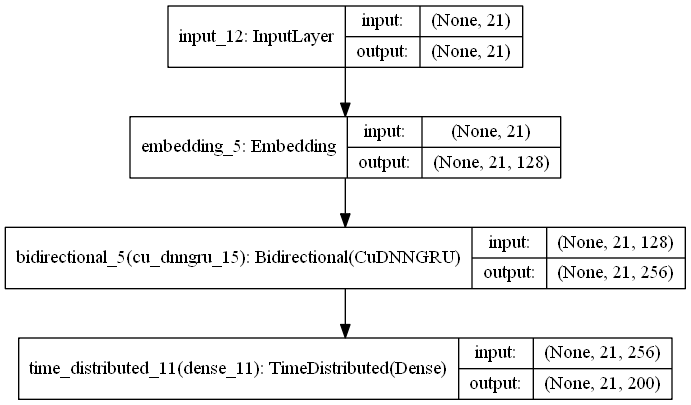

In [246]:
plot_model(combined_rnn_model1, to_file='final_rnn_model.png', show_shapes=True)

In [247]:
history5 = combined_rnn_model1.fit(tmp_x, tmp_y, batch_size=test_batch_size, epochs=30, validation_split=0.2, callbacks=callback_list)

Train on 93744 samples, validate on 23437 samples
Epoch 1/30
93744/93744 [==============================] - 13s 140us/step - loss: 0.5467 - acc: 0.8755 - val_loss: 0.0650 - val_acc: 0.9762
Epoch 2/30
93744/93744 [==============================] - 3s 32us/step - loss: 0.0485 - acc: 0.9802 - val_loss: 0.0388 - val_acc: 0.9828
Epoch 3/30
93744/93744 [==============================] - 3s 32us/step - loss: 0.0345 - acc: 0.9839 - val_loss: 0.0323 - val_acc: 0.9846
Epoch 4/30
93744/93744 [==============================] - 3s 32us/step - loss: 0.0302 - acc: 0.9850 - val_loss: 0.0401 - val_acc: 0.9811
Epoch 5/30
93744/93744 [==============================] - 3s 32us/step - loss: 0.0299 - acc: 0.9849 - val_loss: 0.0324 - val_acc: 0.9842
Epoch 6/30
93744/93744 [==============================] - 3s 32us/step - loss: 0.0284 - acc: 0.9854 - val_loss: 0.0313 - val_acc: 0.9848
Epoch 7/30
93744/93744 [==============================] - 3s 33us/step - loss: 0.0272 - acc: 0.9858 - val_loss: 0.0287 - val_a

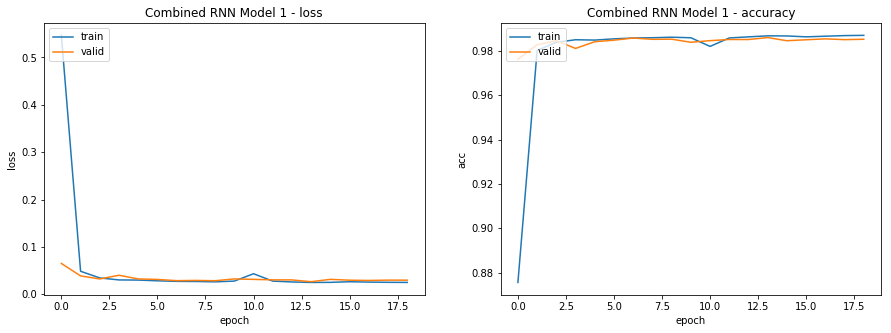

<Figure size 432x288 with 0 Axes>

In [248]:
plt.figure(figsize=(15, 5))
    
ax = plt.subplot(1,2, 1)   
# summarize history for accuracy
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Combined RNN Model 1 - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

ax2 = plt.subplot(1,2, 2)
# summarize history for accuracy
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Combined RNN Model 1 - accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.savefig('final_combined_rnn.png')

In [249]:
res_df5 = evaluate_model2(combined_rnn_model1, x_test, y_test)

BLEU-1: 0.975068
BLEU-2: 0.962787
BLEU-3: 0.954511
BLEU-4: 0.937992


In [279]:
bleu_df.loc["combined1"] = [0.975068, 0.962787, 0.954511, 0.937992]

In [252]:
res_df5.head(10)

,from,target,predicted
0,californie est parfois sec au mois de mai et il est parfois merveilleux en fã©vrier,"[[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]]","[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]"
1,californie est jamais chaud pendant l' automne mais il est jamais sec en mars,"[[california, is, never, hot, during, autumn, but, it, is, never, dry, in, march]]","[california, is, never, warm, during, autumn, but, it, is, never, dry, in, march]"
2,les ã©tats unis est parfois pluvieux en janvier mais il est doux en mai,"[[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]]","[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]"
3,ils aiment les pommes les oranges et les poires,"[[they, like, apples, oranges, and, pears]]","[they, like, apples, oranges, and, pears]"
4,il n'aime les mangues et les fraises,"[[he, dislikes, mangoes, and, strawberries]]","[he, dislikes, strawberries, and, strawberries]"
5,le pamplemousse est son fruit prã©fã©rã© mais le citron est votre favori,"[[the, grapefruit, is, her, favorite, fruit, but, the, lemon, is, your, favorite]]","[the, grapefruit, is, his, favorite, fruit, but, the, lemon, is, your, favorite]"
6,l' inde est parfois agrã©able au cours de l' automne mais il est gã©nã©ralement agrã©able en mars,"[[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, nice, in, march]]","[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, pleasant, in, march]"
7,votre fruit le plus aimã© est la pomme mais son plus aimã© est la pãªche,"[[your, most, loved, fruit, is, the, apple, but, his, most, loved, is, the, peach]]","[your, most, loved, fruit, is, the, apple, but, her, most, loved, is, the, peach]"
8,les ã©tats unis est froid pendant l' hiver et il est parfois relaxant en juin,"[[the, united, states, is, cold, during, winter, and, it, is, sometimes, relaxing, in, june]]","[the, united, states, is, chilly, during, winter, and, it, is, sometimes, relaxing, in, june]"
9,i comme le pamplemousse les pommes et les mangues,"[[i, like, grapefruit, apples, and, mangoes]]","[i, like, grapefruit, apples, and, mangoes]"


#### observation:
The combined model does a fairly good job in translating the test sentences. It achieved BLEU-4 score of 0.938, suggesting it is able to get consecutive words correct majority of the time. Comparing the predicted output with the target output above, we can see that there are only six  differences in the 10 sentences. Three of those differences are related to warm instead of hot, chilly instead of cold, and pleasant instead of nice. All of which means the same thing so are insignificant. Two of the six differences are due to gender pronoun prediction, which is always difficult to get right. The last error was the prediction of strawberry instead of mango, which is possibly due to inadequate number of samples for this particular context. All in all, the model performed very well, considering it is still quite a simple model. This is likely due to the fact the dataset only contained a small set of vocabulary for both English and French, and at the same time there are proportionally large amount of training data

### Model 6: Combined
Combine features of previous models to create a model that incorporates embedding and a bidirectional rnn into one model.

In [253]:
num_rnn_units= 128
learning_rate = 0.01
test_batch_size = 512
embedding_dim = 128

In [254]:
def model_final(input_shape, max_sequence_length, input_vocab_size, output_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param input_vocab_size: Number of unique input language words in the dataset
    :param output_vocab_size: Number of unique output language words in the dataset
    :return: Keras model built, but not trained
    """
    input_seq = Input(input_shape[1:])    
    embed = Embedding(input_vocab_size, embedding_dim, input_length=input_shape[1])(input_seq)
    
    encoded = Bidirectional(CuDNNGRU(num_rnn_units))(embed)
    repeater = RepeatVector(max_sequence_length)(encoded)
    
    decoded = Bidirectional(CuDNNGRU(num_rnn_units, return_sequences=True))(repeater)
    output = TimeDistributed(Dense(output_vocab_size, activation="softmax"))(decoded)
    model = Model(inputs=input_seq, outputs=output)
    print(model.summary()) 
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])    
    return model
#tests.test_model_final(model_final)


print('Final Model Loaded')

Final Model Loaded


In [255]:
modelcheckpoint = ModelCheckpoint(filepath=out_dir+"/combined2.{epoch:02d}.hdf5", monitor="val_loss", save_best_only=True)

earlystopping = EarlyStopping(monitor="val_loss", patience=5)

tensorboard = TensorBoard(log_dir="log_dir", histogram_freq=1)

callback_list = [earlystopping, modelcheckpoint]

In [256]:
# Reshaping the input to work with a combined model
tmp_x = pad(x_train, max_input_seq_length)
tmp_x.shape

(117181, 21)

In [262]:
# Train the neural network
final_rnn_model = model_final(
    tmp_x.shape,
    max_seq_length,
    input_vocab_size+1,
    output_vocab_size+1)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 21)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 21, 128)           44288     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               198144    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 21, 256)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 21, 256)           296448    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 21, 200)           51400     
Total params: 590,280
Trainable params: 590,280
Non-trainable params: 0
____________________________________________________

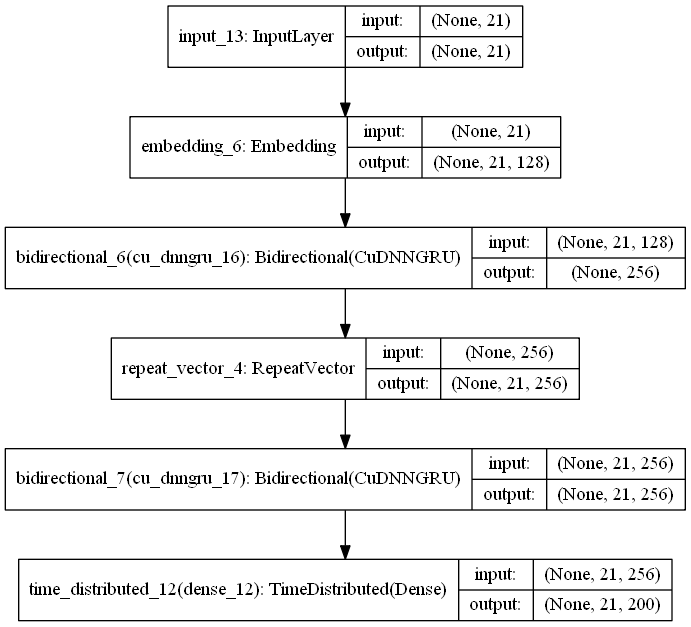

In [258]:
plot_model(final_rnn_model, to_file='final_rnn_model.png', show_shapes=True)

In [263]:
history6 = final_rnn_model.fit(tmp_x, tmp_y, batch_size=test_batch_size, epochs=30, validation_split=0.2, callbacks=callback_list)

Train on 93744 samples, validate on 23437 samples
Epoch 1/30
93744/93744 [==============================] - 7s 70us/step - loss: 1.2608 - acc: 0.6883 - val_loss: 0.5351 - val_acc: 0.8337
Epoch 2/30
93744/93744 [==============================] - 5s 52us/step - loss: 0.3181 - acc: 0.9015 - val_loss: 0.0765 - val_acc: 0.9734
Epoch 3/30
93744/93744 [==============================] - 5s 52us/step - loss: 0.1376 - acc: 0.9597 - val_loss: 0.7143 - val_acc: 0.7957
Epoch 4/30
93744/93744 [==============================] - 5s 52us/step - loss: 0.1212 - acc: 0.9606 - val_loss: 0.0373 - val_acc: 0.9829
Epoch 5/30
93744/93744 [==============================] - 5s 52us/step - loss: 0.0663 - acc: 0.9759 - val_loss: 0.0402 - val_acc: 0.9826
Epoch 6/30
93744/93744 [==============================] - 5s 52us/step - loss: 0.0313 - acc: 0.9846 - val_loss: 0.0284 - val_acc: 0.9854
Epoch 7/30
93744/93744 [==============================] - 5s 55us/step - loss: 0.0265 - acc: 0.9860 - val_loss: 0.0266 - val_acc

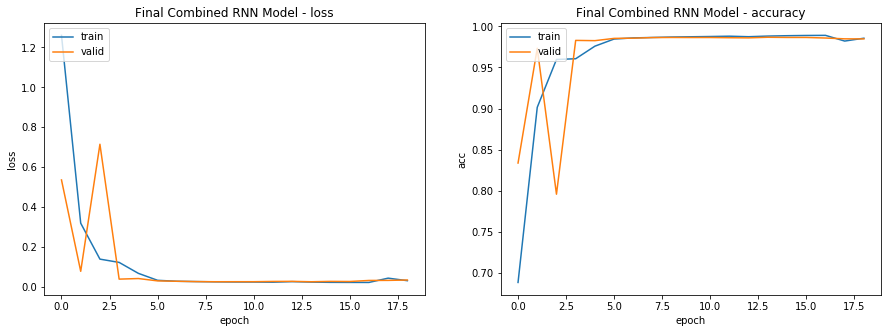

<Figure size 432x288 with 0 Axes>

In [264]:
plt.figure(figsize=(15, 5))
    
ax = plt.subplot(1,2, 1)   
# summarize history for accuracy
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Final Combined RNN Model - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

ax2 = plt.subplot(1,2, 2)
# summarize history for accuracy
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Final Combined RNN Model - accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.savefig('final_combined_rnn.png')

In [265]:
res_df6 = evaluate_model2(final_rnn_model, x_test, y_test)

BLEU-1: 0.973331
BLEU-2: 0.960213
BLEU-3: 0.951683
BLEU-4: 0.934166


In [280]:
bleu_df.loc["combined2"] = [0.973331, 0.960213, 0.951683, 0.934166]

In [269]:
res_df6.head(10)

,from,target,predicted
0,californie est parfois sec au mois de mai et il est parfois merveilleux en fã©vrier,"[[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]]","[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]"
1,californie est jamais chaud pendant l' automne mais il est jamais sec en mars,"[[california, is, never, hot, during, autumn, but, it, is, never, dry, in, march]]","[california, is, never, hot, during, autumn, but, it, is, never, dry, in, march]"
2,les ã©tats unis est parfois pluvieux en janvier mais il est doux en mai,"[[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]]","[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]"
3,ils aiment les pommes les oranges et les poires,"[[they, like, apples, oranges, and, pears]]","[they, like, apples, oranges, and, pears]"
4,il n'aime les mangues et les fraises,"[[he, dislikes, mangoes, and, strawberries]]","[he, dislikes, mangoes, and, strawberries]"
5,le pamplemousse est son fruit prã©fã©rã© mais le citron est votre favori,"[[the, grapefruit, is, her, favorite, fruit, but, the, lemon, is, your, favorite]]","[the, grapefruit, is, her, favorite, fruit, but, the, lemon, is, your, favorite]"
6,l' inde est parfois agrã©able au cours de l' automne mais il est gã©nã©ralement agrã©able en mars,"[[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, nice, in, march]]","[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, pleasant, in, march]"
7,votre fruit le plus aimã© est la pomme mais son plus aimã© est la pãªche,"[[your, most, loved, fruit, is, the, apple, but, his, most, loved, is, the, peach]]","[your, most, loved, fruit, is, the, apple, but, her, most, loved, is, the, peach]"
8,les ã©tats unis est froid pendant l' hiver et il est parfois relaxant en juin,"[[the, united, states, is, cold, during, winter, and, it, is, sometimes, relaxing, in, june]]","[the, united, states, is, chilly, during, winter, and, it, is, sometimes, relaxing, in, june]"
9,i comme le pamplemousse les pommes et les mangues,"[[i, like, grapefruit, apples, and, mangoes]]","[i, like, grapefruit, apples, and, mangoes]"


#### observation:
This appears to be the best performing model, when looking at the sample translations of the test dataset in page 8. It achieved similar performance to the combined model 1, which did not have the encoder-decoder architecture. In the sample prediction, there are only 3 difference between the predicted sentences and the target sentences. Two of the differrences minor (pleasant instead of nice, and chilly instead of cold). The third difference is due to the gender pronoun, which is quite difficult to predict correctly when the sentencesare short and did not have a clear context. The BLEU-4 score of 0.934 suggest the model is able to correctly predict consecutive words correctly majority of the time

### Summary of Results (Side by Side)

In [281]:
df2 = res_df2.rename({'predicted': 'predicted (embed)'}, axis=1) 

df1 = res_df1.rename({'predicted': 'predicted (basic)'}, axis=1) 

df3 = res_df3.rename({'predicted': 'predicted (bidir)'}, axis=1) 

df4 = res_df4.rename({'predicted': 'predicted (encdec)'}, axis=1) 

df5 = res_df5.rename({'predicted': 'predicted (combined1)'}, axis=1) 

df6 = res_df6.rename({'predicted': 'predicted (combined2)'}, axis=1) 

combined = pd.concat([df1, df2['predicted (embed)'], df3['predicted (bidir)'], df4['predicted (encdec)'], df5['predicted (combined1)'], df6['predicted (combined2)']], axis=1, sort=False)

combined = combined.drop(['from'], axis=1)

combined.head(10)

,target,predicted (basic),predicted (embed),predicted (bidir),predicted (encdec),predicted (combined1),predicted (combined2)
0,"[[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]]","[california, is, sometimes, busy, during, august, but, it, is, usually, in, in, summer]","[california, is, sometimes, dry, during, may, but, it, is, sometimes, in, in, autumn]","[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, october]","[california, is, sometimes, dry, during, may, and, it, is, never, mild, in, october]","[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]","[california, is, sometimes, dry, during, may, and, it, is, sometimes, wonderful, in, february]"
1,"[[california, is, never, hot, during, autumn, but, it, is, never, dry, in, march]]","[california, is, never, hot, during, autumn, but, it, is, usually, hot, in, summer]","[california, is, never, hot, during, summer, but, it, is, sometimes, hot, in, march]","[california, is, never, warm, during, autumn, but, it, is, never, dry, in, march]","[california, is, sometimes, warm, during, fall, but, it, is, never, rainy, in, winter]","[california, is, never, warm, during, autumn, but, it, is, never, dry, in, march]","[california, is, never, hot, during, autumn, but, it, is, never, dry, in, march]"
2,"[[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]]","[the, united, states, is, sometimes, quiet, during, january, but, it, is, usually, in, september]","[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]","[the, united, states, is, sometimes, rainy, during, january, but, it, is, wet, in, may]","[the, united, states, is, sometimes, snowy, during, january, but, it, is, beautiful, in, summer]","[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]","[the, united, states, is, sometimes, rainy, during, january, but, it, is, mild, in, may]"
3,"[[they, like, apples, oranges, and, pears]]","[they, dislike, bananas, lemons, and, lemons]","[they, like, mangoes, mangoes, and, lemons]","[they, like, apples, oranges, and, oranges]","[they, like, apples, apples, and, pears]","[they, like, apples, oranges, and, pears]","[they, like, apples, oranges, and, pears]"
4,"[[he, dislikes, mangoes, and, strawberries]]","[he, dislikes, oranges, and, and]","[he, dislikes, oranges, grapes, grapes]","[he, dislikes, grapes, and, pears]","[he, dislikes, mangoes, and, pears]","[he, dislikes, strawberries, and, strawberries]","[he, dislikes, mangoes, and, strawberries]"
5,"[[the, grapefruit, is, her, favorite, fruit, but, the, lemon, is, your, favorite]]","[the, grapefruit, is, her, least, favorite, but, the, lemon, is, my, favorite]","[the, grapefruit, is, her, least, favorite, but, the, lemon, is, your, favorite]","[the, grapefruit, is, his, favorite, fruit, but, the, lemon, is, your, favorite]","[the, grapefruit, is, her, favorite, fruit, but, the, grapefruit, is, his, favorite, favorite]","[the, grapefruit, is, his, favorite, fruit, but, the, lemon, is, your, favorite]","[the, grapefruit, is, her, favorite, fruit, but, the, lemon, is, your, favorite]"
6,"[[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, nice, in, march]]","[india, is, never, dry, during, november, and, it, is, never, in, in]","[india, is, never, hot, during, august, but, it, is, never, in, in, autumn]","[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, nice, in, march]","[india, is, sometimes, warm, during, autumn, but, it, is, usually, cold, in, winter]","[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, pleasant, in, march]","[india, is, sometimes, pleasant, during, autumn, but, it, is, usually, pleasant, in, march]"
7,"[[your, most, loved, fruit, is, the, apple, but, his, most, loved, is, the, peach]]","[your, least, loved, fruit, is, the, strawberry, bu

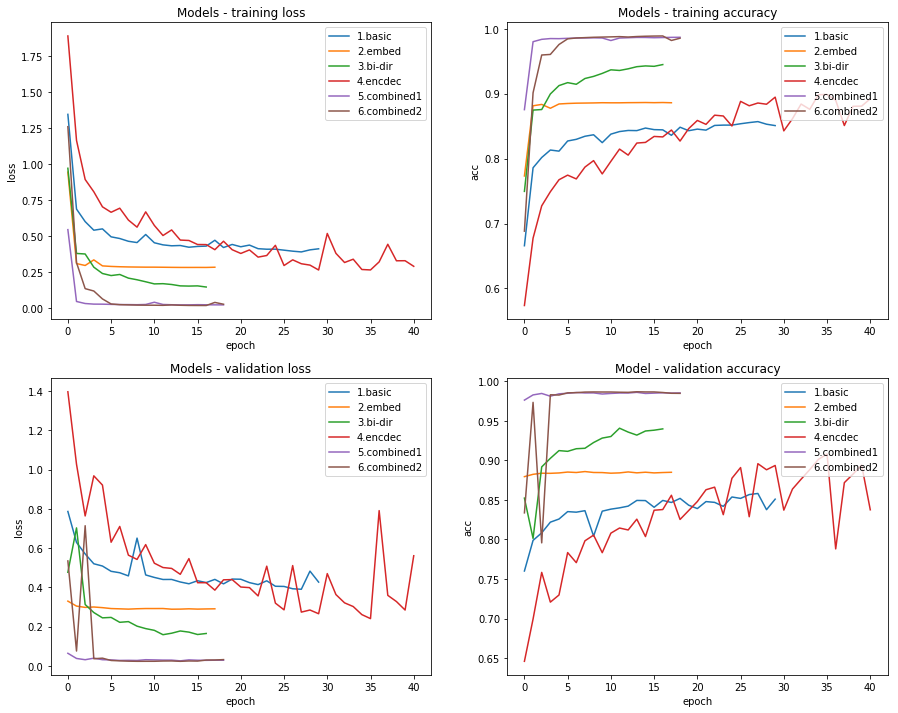

In [271]:
plt.figure(figsize=(15, 12))
    
ax = plt.subplot(2,2, 1)   
# summarize history for accuracy
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.plot(history5.history['loss'])
plt.plot(history6.history['loss'])
plt.title('Models - training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1.basic', '2.embed', '3.bi-dir', '4.encdec', '5.combined1', '6.combined2'], loc='upper right')

ax2 = plt.subplot(2,2, 2)
# summarize history for accuracy
plt.plot(history1.history['acc'])
plt.plot(history2.history['acc'])
plt.plot(history3.history['acc'])
plt.plot(history4.history['acc'])
plt.plot(history5.history['acc'])
plt.plot(history6.history['acc'])
plt.title('Models - training accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['1.basic', '2.embed', '3.bi-dir', '4.encdec', '5.combined1', '6.combined2'], loc='upper right')

ax = plt.subplot(2,2, 3)   
# summarize history for accuracy
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_loss'])
plt.plot(history6.history['val_loss'])
plt.title('Models - validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1.basic', '2.embed', '3.bi-dir', '4.encdec', '5.combined1', '6.combined2'], loc='upper right')

ax2 = plt.subplot(2,2, 4)
# summarize history for accuracy
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['val_acc'])
plt.plot(history3.history['val_acc'])
plt.plot(history4.history['val_acc'])
plt.plot(history5.history['val_acc'])
plt.plot(history6.history['val_acc'])
plt.title('Model - validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['1.basic', '2.embed', '3.bi-dir', '4.encdec', '5.combined1', '6.combined2'], loc='upper right')
plt.show()


In [282]:
bleu_df

,bleu-1,bleu-2,bleu-3,bleu-4
basic,0.748662,0.651351,0.603070,0.507528
embed,0.799664,0.719834,0.684355,0.607672
bidir,0.896982,0.853186,0.828067,0.773097
encdec,0.750845,0.630631,0.556733,0.424679
combined1,0.975068,0.962787,0.954511,0.937992
combined2,0.973331,0.960213,0.951683,0.934166


<Figure size 864x864 with 0 Axes>

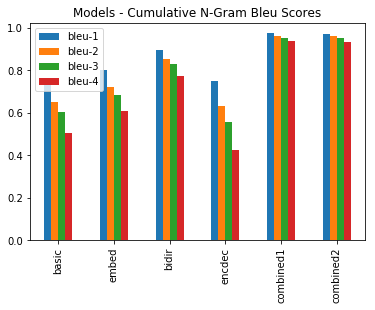

In [285]:
bleu_df.plot(kind="bar", title="Models - Cumulative N-Gram Bleu Scores")